# 加载保存的帧数据进行分析

本notebook演示如何加载和分析从BLE Host应用程序保存的帧数据。基于load_save_frames.ipynb。

本代码用于实现对新增 Direction Finding 的帧的读取和解析。

## 使用说明

1. 修改下面的 `filepath` 变量，指向您保存的数据文件（支持JSON或JSONL格式）
2. 按顺序执行各个cell
3. 可以根据需要修改和扩展分析代码

## 文件格式支持

- **JSON格式**（v3.5.0及以下）：传统的单文件JSON格式
- **JSONL格式**（v3.6.0+）：增量记录的JSONL格式（.jsonl），每行一个JSON对象
- **自动检测**：程序会自动检测文件格式并选择相应的加载方式


In [3]:
# 导入必要的库
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 添加src目录到路径（从项目根目录运行）
project_root = Path().resolve()
if (project_root / 'src').exists():
    sys.path.insert(0, str(project_root / 'src'))
else:
    # 如果在examples目录中运行，需要向上一级
    project_root = project_root.parent
    sys.path.insert(0, str(project_root / 'src'))

try:
    from data_saver import DataSaver
    print("✓ 成功导入 data_saver 模块")
except ImportError as e:
    print(f"✗ 导入失败: {e}")
    print(f"当前工作目录: {os.getcwd()}")
    print(f"项目根目录: {project_root}")
    print(f"src路径: {project_root / 'src'}")

# 导入信号处理工具函数
try:
    from utils import signal_algrithom as sig_algm
    # 或者从 utils 包直接导入（如果已在 __init__.py 中导出）
    # from utils import median_filter_1d, hampel_filter
    print("✓ 成功导入信号处理函数")
except ImportError as e:
    print(f"⚠️ 导入信号处理函数失败: {e}")
    print("  将使用本地定义的函数")


✓ 成功导入 data_saver 模块
✓ 成功导入信号处理函数


## 1. 加载数据

请修改下面的文件路径，指向您保存的数据文件（支持JSON或JSONL格式）。

**注意**：
- v3.6.0+版本使用JSONL格式（.jsonl），支持增量记录
- v3.5.0及以下版本使用JSON格式（.json）
- 程序会自动检测文件格式并加载


In [6]:
# 设置要加载的文件路径
# 可以修改为您的文件路径，或使用相对路径
# 支持JSON格式（v3.5.0及以下）和JSONL格式（v3.6.0+）
# filepath = "./sampleData/DF_frames_all_20251228_174609.json"  # 修改这里
# 或者使用JSONL格式文件（v3.6.0+）：
filepath = "./sampleData/DF_frames_all_20260110_163157.jsonl"
# 如果文件不在当前目录，可以使用完整路径或相对路径
# filepath = "../data_exp/frames_all_20231206_120000.json"

# 检查文件是否存在
if not os.path.exists(filepath):
    print(f"⚠️  文件不存在: {filepath}")
    print(f"当前目录: {os.getcwd()}")
    print("\n请修改上面的 filepath 变量，指向正确的文件路径")
else:
    print(f"✓ 找到文件: {filepath}")
    file_size_mb = os.path.getsize(filepath) / 1024 / 1024
    print(f"文件大小: {file_size_mb:.2f} MB")
    
    # 检测文件格式
    if filepath.endswith('.jsonl') or filepath.endswith('.ndjson'):
        print("文件格式: JSONL (v3.6.0+)")
    elif filepath.endswith('.json'):
        print("文件格式: JSON (v3.5.0及以下)")
    else:
        print("文件格式: 未知（将自动检测）")

# 加载数据（自动检测格式）
saver = DataSaver()
print(f"\n正在加载: {filepath}")

data = saver.load_frames(filepath)

if data is None:
    print("✗ 加载失败")
    print("  可能的原因：")
    print("  1. 文件格式不正确")
    print("  2. 文件损坏")
    print("  3. 文件版本不兼容")
else:
    print("✓ 加载成功")
    frames = data.get('frames', [])
    print(f"✓ 共加载 {len(frames)} 帧数据")
    
    # 显示文件格式信息（如果是JSONL）
    if 'file_format' in data:
        print(f"检测到的文件格式: {data['file_format']}")
    if 'meta' in data:
        meta = data['meta']
        print(f"文件版本: {meta.get('app_version', 'N/A')}")
        print(f"帧类型: {meta.get('frame_type', 'N/A')}")
        print(f"开始时间: {meta.get('started_at_iso', 'N/A')}")


✓ 找到文件: ./sampleData/DF_frames_all_20260110_163157.jsonl
文件大小: 1.79 MB
文件格式: JSONL (v3.6.0+)

正在加载: ./sampleData/DF_frames_all_20260110_163157.jsonl
✓ 加载成功
✓ 共加载 10803 帧数据


## 2. 查看文件信息


In [7]:
# 显示文件元数据
if data:
    print("=== 文件信息 ===")
    print(f"版本: {data.get('version', 'N/A')}")
    print(f"保存时间: {data.get('saved_at', 'N/A')}")
    print(f"原始总帧数: {data.get('total_frames', 0)}")
    print(f"保存的帧数: {data.get('saved_frames', 0)}")
    
    max_frames_param = data.get('max_frames_param')
    if max_frames_param is None:
        print(f"保存模式: 全部帧")
    else:
        print(f"保存模式: 最近 {max_frames_param} 帧")
    
    # 显示第一帧和最后一帧的信息
    if frames:
        print(f"\n第一帧: index={frames[0]['index']}, timestamp={frames[0]['timestamp_ms']} ms")
        print(f"最后一帧: index={frames[-1]['index']}, timestamp={frames[-1]['timestamp_ms']} ms")
        
        # 计算时间跨度
        time_span = (frames[-1]['timestamp_ms'] - frames[0]['timestamp_ms']) / 1000.0
        print(f"时间跨度: {time_span:.2f} 秒")
        
        # 计算平均帧率
        if len(frames) > 1:
            intervals = []
            for i in range(1, len(frames)):
                interval = (frames[i]['timestamp_ms'] - frames[i-1]['timestamp_ms']) / 1000.0
                intervals.append(interval)
            if intervals:
                avg_interval = np.mean(intervals)
                print(f"平均帧间隔: {avg_interval:.3f} 秒")
                print(f"平均帧率: {1.0/avg_interval:.2f} 帧/秒")


=== 文件信息 ===
版本: 3.6.0
保存时间: 2026-01-10T16:31:57.747791
原始总帧数: 10804
保存的帧数: 10804
保存模式: 全部帧

第一帧: index=0, timestamp=18482 ms
最后一帧: index=10803, timestamp=235042 ms
时间跨度: 216.56 秒
平均帧间隔: 0.020 秒
平均帧率: 49.88 帧/秒


## 3. 查看前10帧的详细信息


In [8]:
# 查看前10帧的详细信息
if frames:
    print(f"{'序号':<4}{'信道':<4} {'幅值':<8} {'Local幅值(=幅值)':<10} {'功率(P_avg)':<12}")
    for idx in range(min(10, len(frames))):
        frame = frames[idx]
        frames_data_to_show = frame.get('channels', {})
        for frame_key, frame_data in frames_data_to_show.items():
            # 安全获取字段值，如果为None则使用默认值
            amplitude = frame_data.get('amplitude') or 0.0
            local_amplitude = frame_data.get('local_amplitude') or amplitude  # 如果不存在，使用amplitude
            p_avg = frame_data.get('p_avg') or (amplitude * amplitude if amplitude > 0 else 0.0)  # 如果不存在，从amplitude计算
            
            print(
                f"{idx:<6}"
                f"{frame_key:<6}"
                f"{amplitude:<12.3f}"
                f"{local_amplitude:<16.3f}"
                f"{p_avg:<12.2f}"
            )
                

序号  信道   幅值       Local幅值(=幅值) 功率(P_avg)   
0     3     132.556     132.556         17571.00    
1     3     138.553     138.553         19197.00    
2     3     129.163     129.163         16683.00    
3     3     143.621     143.621         20627.00    
4     3     141.071     141.071         19901.00    
5     3     149.060     149.060         22219.00    
6     3     133.424     133.424         17802.00    
7     3     133.390     133.390         17793.00    
8     3     151.324     151.324         22899.00    
9     3     135.779     135.779         18436.00    


## 4. 提取通道数据

选择一个通道，提取其所有帧的数据进行分析。


In [9]:
# 选择要分析的通道（可以修改）
channel = 0

# 首先检查哪些通道在数据中可用
if frames:
    all_channels = set()
    for frame in frames:
        all_channels.update(frame['channels'].keys())
    print(f"数据中可用的通道: {sorted(all_channels)[:20]}...")  # 只显示前20个
    print(f"总通道数: {len(all_channels)}")
    
    # 检查通道号类型并尝试匹配
    channel_found = False
    # 尝试整数和字符串两种类型
    channel_keys = [channel, str(channel), int(channel)]
    
    for ch_key in channel_keys:
        if ch_key in all_channels:
            channel = ch_key  # 使用找到的键
            channel_found = True
            print(f"✓ 找到通道: {ch_key} (类型: {type(ch_key).__name__})")
            break
    
    if not channel_found:
        print(f"⚠️  警告: 通道 {channel} 在数据中不存在")
        print(f"建议使用以下通道之一: {sorted(all_channels)[:10]}")
        # 使用第一个可用通道作为默认值
        if all_channels:
            channel = sorted(all_channels)[0]
            print(f"自动使用通道: {channel}")

# 提取该通道的所有数据
amplitudes = []
phases = []
local_amplitudes = []
remote_amplitudes = []
indices = []
timestamps_ms = []

for frame in frames:
    channels = frame['channels']
    # 尝试多种方式匹配通道
    ch_data = None
    if channel in channels:
        ch_data = channels[channel]
    elif str(channel) in channels:
        ch_data = channels[str(channel)]
    elif int(channel) in channels:
        ch_data = channels[int(channel)]
    
    if ch_data:
        amplitudes.append(ch_data['amplitude'])
        phases.append(ch_data['phase'])
        local_amplitudes.append(ch_data['local_amplitude'])
        remote_amplitudes.append(ch_data['remote_amplitude'])
        indices.append(frame['index'])
        timestamps_ms.append(frame['timestamp_ms'])

# 转换为numpy数组
amplitudes = np.array(amplitudes)
phases = np.array(phases)
local_amplitudes = np.array(local_amplitudes)
remote_amplitudes = np.array(remote_amplitudes)
indices = np.array(indices)
timestamps_ms = np.array(timestamps_ms)

print(f"\n✓ 提取通道 {channel} 的数据")
print(f"  数据点数: {len(amplitudes)}")

# 检查数据是否为空
if len(amplitudes) == 0:
    print("  ⚠️  警告: 没有提取到任何数据！")
    print("  可能的原因:")
    print("  1. 该通道在所有帧中都不存在")
    print("  2. 通道号类型不匹配（整数 vs 字符串）")
    print("  请检查上面的可用通道列表，并修改 channel 变量")
else:
    print(f"  幅值范围: {np.min(amplitudes):.2f} - {np.max(amplitudes):.2f}")
    print(f"  幅值均值: {np.mean(amplitudes):.2f}")
    print(f"  幅值标准差: {np.std(amplitudes):.2f}")


数据中可用的通道: [3]...
总通道数: 1
⚠️  警告: 通道 0 在数据中不存在
建议使用以下通道之一: [3]
自动使用通道: 3

✓ 提取通道 3 的数据
  数据点数: 10803
  幅值范围: 36.67 - 181.02
  幅值均值: 69.98
  幅值标准差: 24.26


## 5. 数据可视化


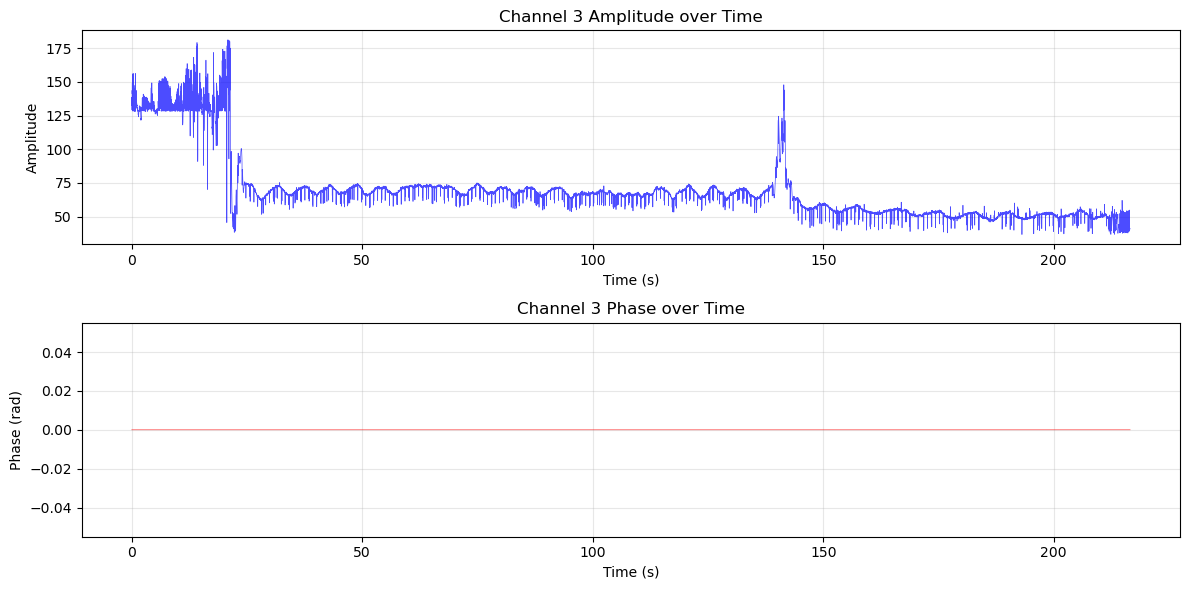

In [10]:
# 绘制幅值随时间的变化
if len(amplitudes) > 0:
    plt.figure(figsize=(12, 6))
    
    # 将时间戳转换为相对时间（秒）
    time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0
    
    plt.subplot(2, 1, 1)
    plt.plot(time_sec, amplitudes, 'b-', linewidth=0.5, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Channel {channel} Amplitude over Time')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time_sec, phases, 'r-', linewidth=0.5, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Phase (rad)')
    plt.title(f'Channel {channel} Phase over Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  无法绘图: 没有数据可显示")


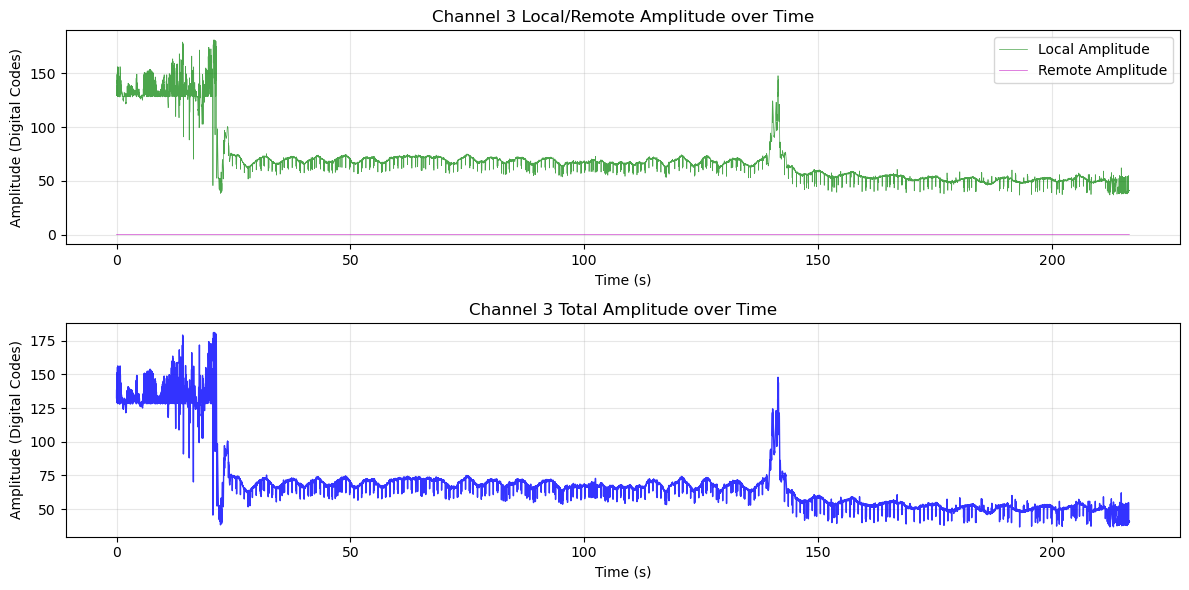

In [11]:
# 对比Local和Remote幅值
if len(amplitudes) > 0:
    plt.figure(figsize=(12, 6))
    
    # 将时间戳转换为相对时间（秒）
    time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0


    plt.subplot(2, 1, 1)
    plt.plot(time_sec, local_amplitudes, 'g-', label='Local Amplitude', linewidth=0.5, alpha=0.7)
    plt.plot(time_sec, remote_amplitudes, 'm-', label='Remote Amplitude', linewidth=0.5, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (Digital Codes)')
    plt.title(f'Channel {channel} Local/Remote Amplitude over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time_sec, amplitudes, 'b-', label='Total Amplitude', linewidth=1, alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (Digital Codes)')
    plt.title(f'Channel {channel} Total Amplitude over Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  无法绘图: 没有数据可显示")


## add.1 滤除尖刺
此项使用中值滤波或hampel 滤波，去除幅值/相位信息中的尖刺，要点是窗口需要尽可能接近突变尖刺的宽度，且远远不及呼吸的长度。也就是1-3个点左右（对于2Hz采样率来说）。hampel一般默认$\delta=3$

### 中值
在每一个时间点 $n$：
1. 取一个**很短的局部窗口**
   $\{x[n-k], \dots, x[n], \dots, x[n+k]\}$
2. **排序**
3. 用**中位数**替代当前值
### hampel
在窗口内计算：
- 中位数：
  $m = \text{median}(x)$
- 中位绝对偏差（MAD）：
  $\text{MAD} = \text{median}(|x - m|)$
用 MAD 估计标准差：
$\sigma \approx 1.4826 \cdot \text{MAD}$
#### ✅ 判决规则
$|x[n] - m| > \gamma \sigma$

- 若成立 → 认为是异常 → 用中位数替换
- 否则 → 保留原值
#### ✅ Hampel 需要阈值吗？

> **需要，但阈值非常“通用”**

- $\gamma = 3$（几乎是默认值）

In [12]:
# 对所有信道幅值/相位分别应用中值滤波和hampel 滤波，然后对照效果

# 提取所有通道的所有变量数据
print("正在提取所有通道的数据...")
all_channels_data = {}

if frames:
    # 获取所有通道号
    all_channels = set()
    for frame in frames:
        channels = frame.get('channels', {})
        all_channels.update(channels.keys())
    
    all_channels = sorted([int(ch) if isinstance(ch, str) and ch.isdigit() else ch for ch in all_channels])
    print(f"找到 {len(all_channels)} 个通道")
    
    # 为每个通道提取数据
    for ch in all_channels:
        ch_str = str(ch)
        ch_data_dict = {
            'amplitudes': [],
            'phases': [],
            'local_amplitudes': [],
            'remote_amplitudes': [],
            'local_phases': [],
            'remote_phases': [],
            'timestamps_ms': []
        }
        
        for frame in frames:
            channels = frame.get('channels', {})
            ch_data = None
            
            # 尝试多种方式匹配通道
            if ch in channels:
                ch_data = channels[ch]
            elif ch_str in channels:
                ch_data = channels[ch_str]
            elif int(ch) in channels:
                ch_data = channels[int(ch)]
            
            if ch_data:
                ch_data_dict['amplitudes'].append(ch_data.get('amplitude', 0))
                ch_data_dict['phases'].append(ch_data.get('phase', 0))
                ch_data_dict['local_amplitudes'].append(ch_data.get('local_amplitude', 0))
                ch_data_dict['remote_amplitudes'].append(ch_data.get('remote_amplitude', 0))
                ch_data_dict['local_phases'].append(ch_data.get('local_phase', 0))
                ch_data_dict['remote_phases'].append(ch_data.get('remote_phase', 0))
                ch_data_dict['timestamps_ms'].append(frame.get('timestamp_ms', 0))
        
        # 转换为numpy数组，这一步还真是必要的，不知原因
        for key in ch_data_dict:
                print(f"数据：{key}原始类型为：{type(ch_data_dict[key])}")
                ch_data_dict[key] = np.array(ch_data_dict[key])
        
        all_channels_data[ch] = ch_data_dict

print(f"✓ 成功提取 {len(all_channels_data)} 个通道的数据")


正在提取所有通道的数据...
找到 1 个通道
数据：amplitudes原始类型为：<class 'list'>
数据：phases原始类型为：<class 'list'>
数据：local_amplitudes原始类型为：<class 'list'>
数据：remote_amplitudes原始类型为：<class 'list'>
数据：local_phases原始类型为：<class 'list'>
数据：remote_phases原始类型为：<class 'list'>
数据：timestamps_ms原始类型为：<class 'list'>
✓ 成功提取 1 个通道的数据



正在应用滤波（窗口大小=10，Hampel阈值=3）...
✓ 滤波完成
通道0不存在，使用通道 3


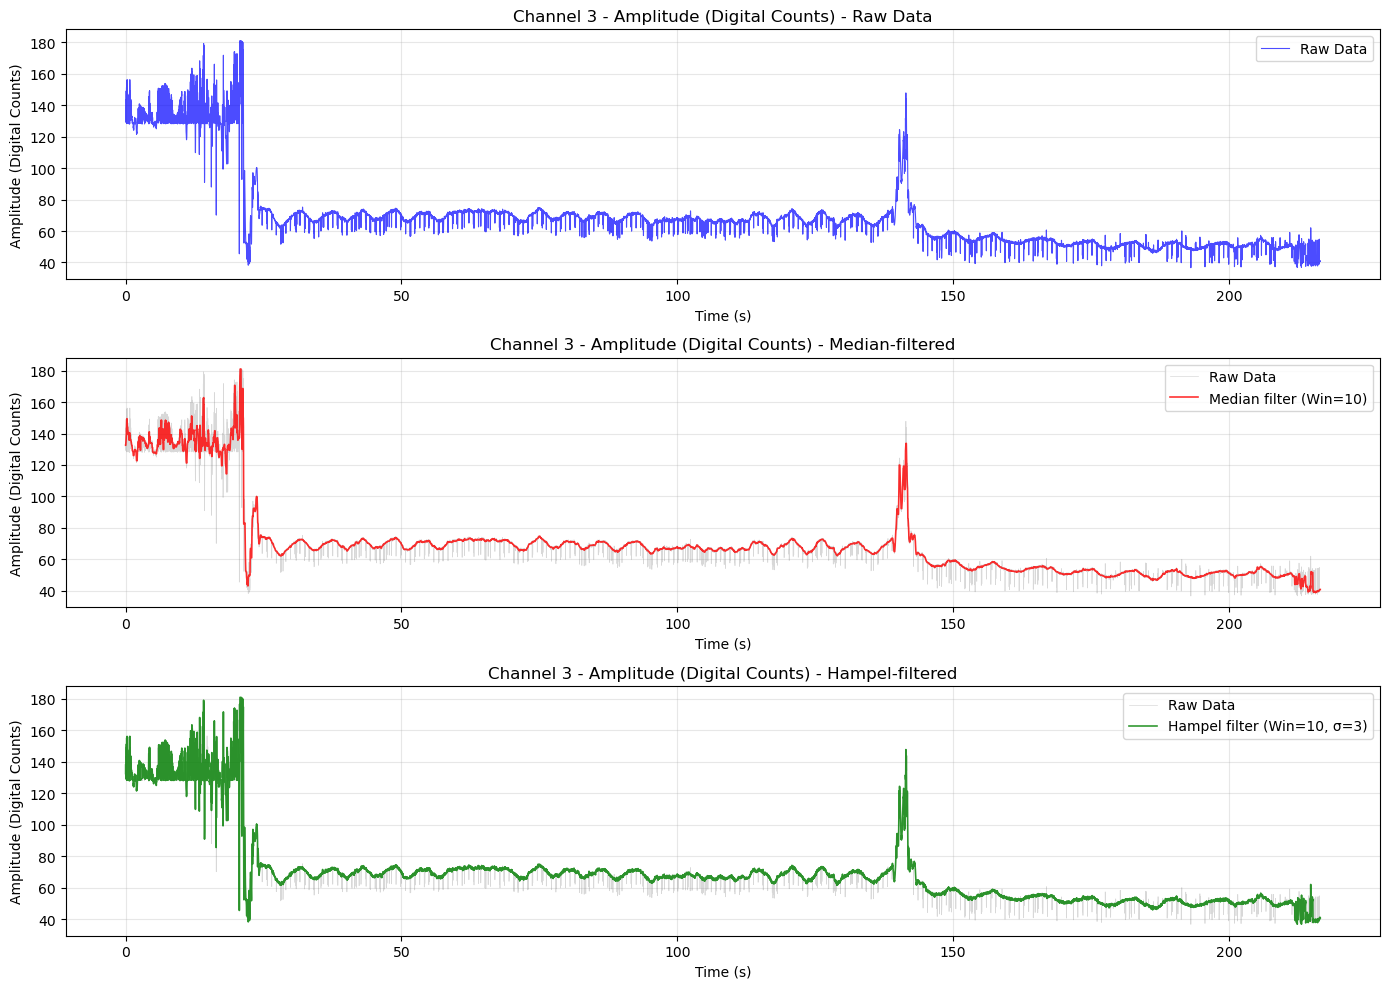

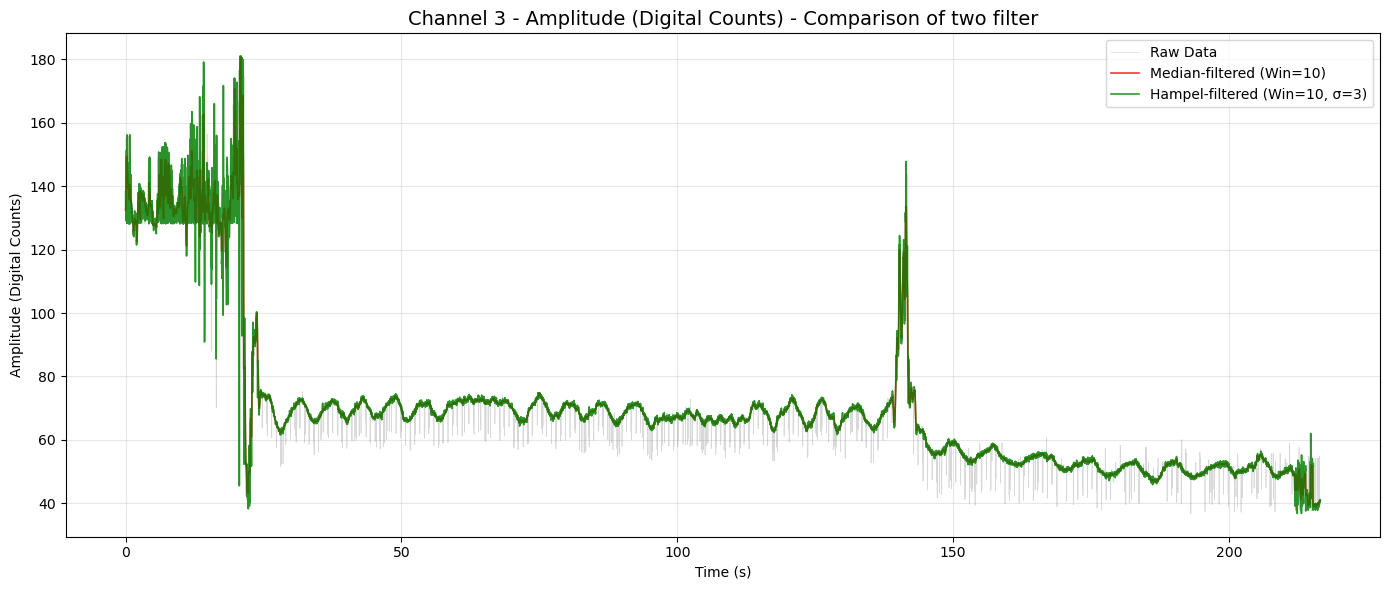


=== 通道 3 - Amplitude (Digital Counts) 滤波效果统计 ===
原始数据:
  均值: 69.9754, 标准差: 24.2586
  最大值: 181.0193, 最小值: 36.6742

中值滤波后:
  均值: 70.2774, 标准差: 23.9485
  最大值: 181.0193, 最小值: 38.8716
  变化点数: 9547 / 10803

Hampel滤波后:
  均值: 70.2900, 标准差: 24.1232
  最大值: 181.0193, 最小值: 36.7831
  变化点数: 694 / 10803


In [13]:

# 对所有通道的所有变量应用中值滤波和Hampel滤波，存储到新dict filtered_data
window_size =  10 # 窗口大小：1-3个点（对于2Hz采样率），实际时间窗长度不超过0.2s即可
n_sigma = 3  # Hampel滤波的阈值倍数


print(f"\n正在应用滤波（窗口大小={window_size}，Hampel阈值={n_sigma}）...")

filtered_data = {}
for ch in all_channels_data:
    filtered_data[ch] = {}
    ch_data = all_channels_data[ch]
    
    # 对每个变量进行滤波
    for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes', 'local_phases', 'remote_phases']:
        if len(ch_data[var_name]) > 0:
            # 中值滤波
            median_filtered = sig_algm.median_filter_1d(ch_data[var_name], window_size=window_size)
            # Hampel滤波
            hampel_filtered = sig_algm.hampel_filter(ch_data[var_name], window_size=window_size, n_sigma=n_sigma)
            
            filtered_data[ch][var_name] = {
                'original': ch_data[var_name],
                'median': median_filtered,
                'hampel': hampel_filtered
            }

print("✓ 滤波完成")

# 选择任意一个通道和任意一个变量进行可视化比较
# 这里选择通道0的总幅值作为示例
demo_channel = 0
demo_variable = 'amplitudes'  # 可以选择: amplitudes, phases, local_amplitudes, remote_amplitudes, local_phases, remote_phases

# 如果通道0不存在，使用第一个可用通道
if demo_channel not in filtered_data and len(filtered_data) > 0:
    demo_channel = list(filtered_data.keys())[0]
    print(f"通道0不存在，使用通道 {demo_channel}")

if demo_channel in filtered_data and demo_variable in filtered_data[demo_channel]:
    # 获取时间轴（转换为秒）
    channels = frame['channels']
    # 尝试多种方式匹配通道
    ch_data = None
    if channel in channels:
        ch_data = channels[channel]
    
    # 获取数据
    original = filtered_data[demo_channel][demo_variable]['original']
    median_filtered = filtered_data[demo_channel][demo_variable]['median']
    hampel_filtered = filtered_data[demo_channel][demo_variable]['hampel']
    
    # 绘制对比图
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # 变量名称映射
    var_names = {
        'amplitudes': 'Amplitude (Digital Counts)',
        'phases': 'Phase (rad)',
        'local_amplitudes': 'Amplitude (Digital Counts)',
        'remote_amplitudes': 'Amplitude (Digital Counts)',
        'local_phases': 'Local Phase (rad)',
        'remote_phases': 'Remote Phase (rad)'
    }
    var_display_name = var_names.get(demo_variable, demo_variable)
    
    # 原始数据
    axes[0].plot(time_sec, original, 'b-', linewidth=0.8, alpha=0.7, label='Raw Data')
    axes[0].set_title(f'Channel {demo_channel} - {var_display_name} - Raw Data', fontsize=12)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel(var_display_name)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # 中值滤波结果
    axes[1].plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='Raw Data')
    axes[1].plot(time_sec, median_filtered, 'r-', linewidth=1.2, alpha=0.8, label=f'Median filter (Win={window_size})')
    axes[1].set_title(f'Channel {demo_channel} - {var_display_name} - Median-filtered', fontsize=12)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel(var_display_name)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Hampel滤波结果
    axes[2].plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='Raw Data')
    axes[2].plot(time_sec, hampel_filtered, 'g-', linewidth=1.2, alpha=0.8, label=f'Hampel filter (Win={window_size}, σ={n_sigma})')
    axes[2].set_title(f'Channel {demo_channel} - {var_display_name} - Hampel-filtered', fontsize=12)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel(var_display_name)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 绘制两种滤波方法的直接对比
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    ax.plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='Raw Data')
    ax.plot(time_sec, median_filtered, 'r-', linewidth=1.2, alpha=0.8, label=f'Median-filtered (Win={window_size})')
    ax.plot(time_sec, hampel_filtered, 'g-', linewidth=1.2, alpha=0.8, label=f'Hampel-filtered (Win={window_size}, σ={n_sigma})')
    ax.set_title(f'Channel {demo_channel} - {var_display_name} - Comparison of two filter', fontsize=14)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(var_display_name)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 打印统计信息
    print(f"\n=== 通道 {demo_channel} - {var_display_name} 滤波效果统计 ===")
    print(f"原始数据:")
    print(f"  均值: {np.mean(original):.4f}, 标准差: {np.std(original):.4f}")
    print(f"  最大值: {np.max(original):.4f}, 最小值: {np.min(original):.4f}")
    print(f"\n中值滤波后:")
    print(f"  均值: {np.mean(median_filtered):.4f}, 标准差: {np.std(median_filtered):.4f}")
    print(f"  最大值: {np.max(median_filtered):.4f}, 最小值: {np.min(median_filtered):.4f}")
    print(f"  变化点数: {np.sum(original != median_filtered)} / {len(original)}")
    print(f"\nHampel滤波后:")
    print(f"  均值: {np.mean(hampel_filtered):.4f}, 标准差: {np.std(hampel_filtered):.4f}")
    print(f"  最大值: {np.max(hampel_filtered):.4f}, 最小值: {np.min(hampel_filtered):.4f}")
    print(f"  变化点数: {np.sum(original != hampel_filtered)} / {len(original)}")
    
else:
    print(f"⚠️ 无法找到通道 {demo_channel} 的变量 {demo_variable}")



## add.2 去直流偏置，趋势
- 截止频率：
  - **0.03–0.05 Hz**
- 阶数：
  - **1–2 阶 Butterworth**
- 必须零相位
📌 原因：
- 2 Hz 下，高阶 IIR 很容易畸变

✓ Using highpass_filter_zero_phase from utils.signal_algrithom

Applying highpass filter to median-filtered data...
Sampling rate: 50.0 Hz
Cutoff frequency: 0.05 Hz
✓ Highpass filtering completed for 1 channels
Channel 0 not found, using channel 3


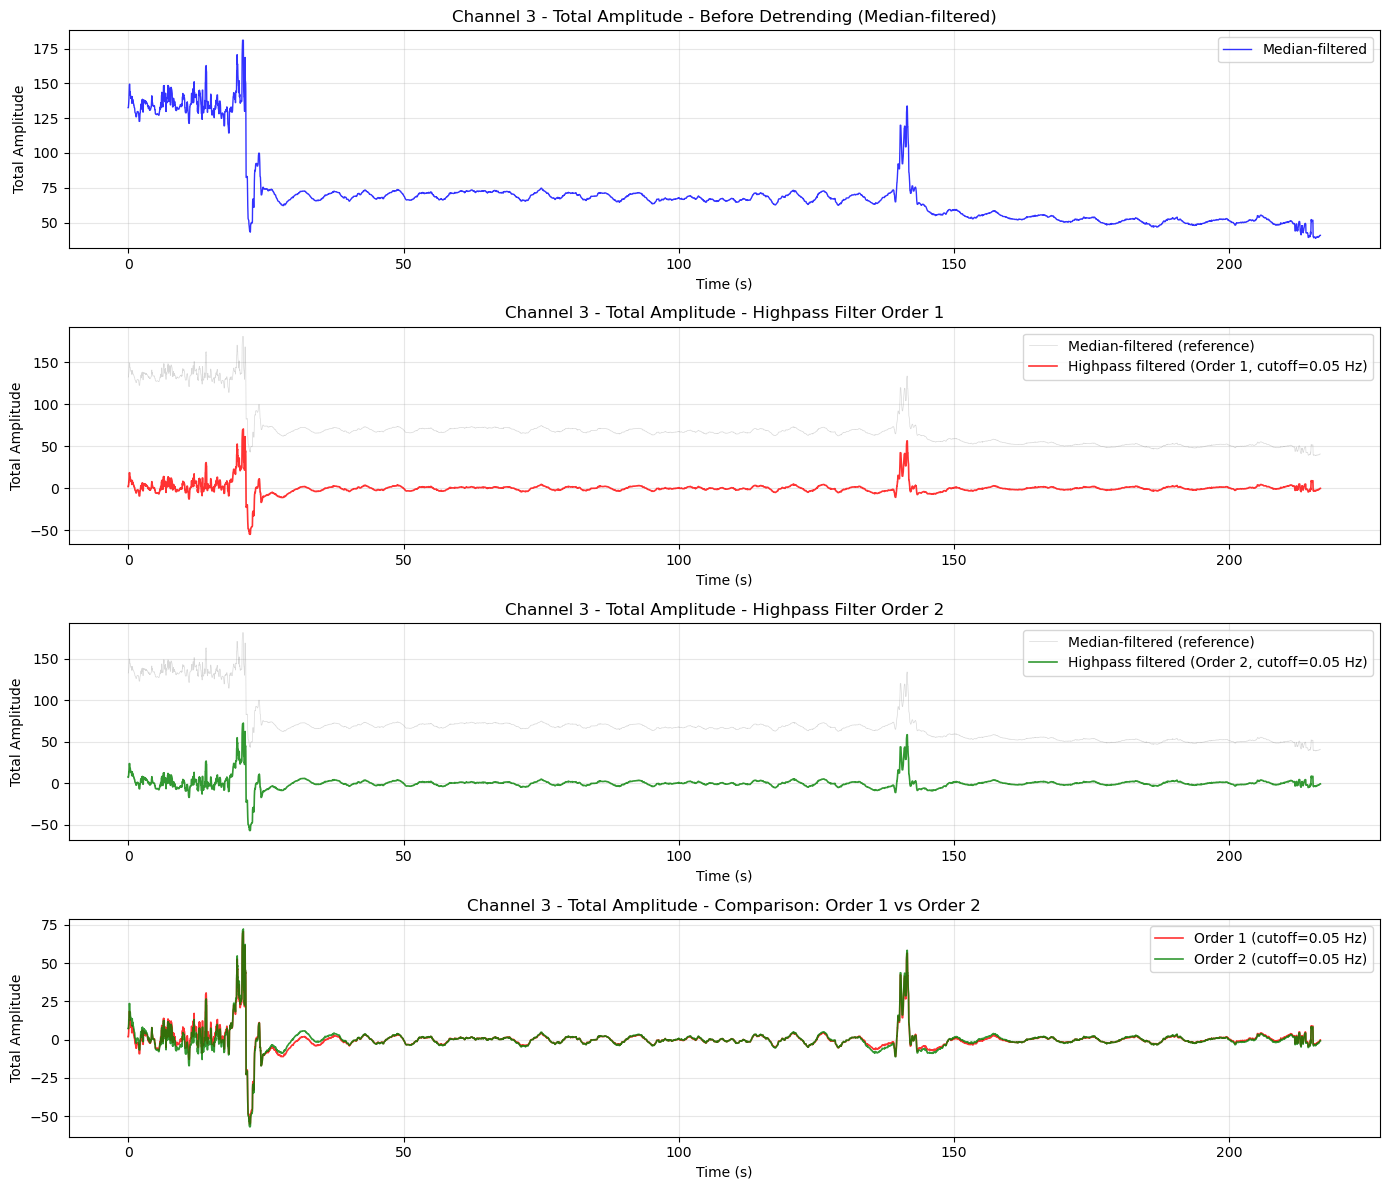


=== Channel 3 - Total Amplitude - Detrending Statistics ===
Median-filtered (before detrending):
  Mean: 70.2774, Std: 23.9485
  Max: 181.0193, Min: 38.8716

Highpass filtered (Order 1):
  Mean: 0.1121, Std: 6.8310
  Max: 70.7239, Min: -54.9856
  Mean change: 70.1654

Highpass filtered (Order 2):
  Mean: 0.0870, Std: 7.1331
  Max: 72.3364, Min: -56.9193
  Mean change: 70.1904


In [14]:
# Apply highpass filter to median-filtered data for detrending (baseline drift removal)

from scipy.signal import butter, filtfilt

# Import highpass filter function from utils
try:
    from utils.signal_algrithom import highpass_filter_zero_phase
    print("✓ Using highpass_filter_zero_phase from utils.signal_algrithom")
except ImportError:
    # Fallback: define locally if import fails
    def highpass_filter_zero_phase(data, cutoff_freq, sampling_rate, order=1):
        """Zero-phase highpass filter using Butterworth filter with filtfilt"""
        nyquist = sampling_rate / 2.0
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
        filtered_data = filtfilt(b, a, data)
        return filtered_data
    print("⚠️ Using locally defined highpass_filter_zero_phase function")

# Parameters
sampling_rate = 50.0  # Hz (2 Hz sampling rate as mentioned)
cutoff_freq = 0.05  # Hz (cutoff frequency for removing baseline drift, adjust as needed)

print(f"\nApplying highpass filter to median-filtered data...")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Cutoff frequency: {cutoff_freq} Hz")

# Apply highpass filter with order 1 and order 2 to all channels and variables
detrended_data = {}

for ch in filtered_data:
    detrended_data[ch] = {}
    ch_filtered = filtered_data[ch]
    
    # Process each variable
    for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes', 'local_phases', 'remote_phases']:
        if var_name in ch_filtered and len(ch_filtered[var_name]['median']) > 0:
            median_filtered = ch_filtered[var_name]['median']
            
            # Apply highpass filter with order 1
            detrended_order1 = sig_algm.highpass_filter_zero_phase(
                median_filtered, 
                cutoff_freq=cutoff_freq, 
                sampling_rate=sampling_rate, 
                order=1
            )
            
            # Apply highpass filter with order 2
            detrended_order2 = sig_algm.highpass_filter_zero_phase(
                median_filtered, 
                cutoff_freq=cutoff_freq, 
                sampling_rate=sampling_rate, 
                order=2
            )
            
            detrended_data[ch][var_name] = {
                'median_filtered': median_filtered,
                'detrended_order1': detrended_order1,
                'detrended_order2': detrended_order2
            }

print(f"✓ Highpass filtering completed for {len(detrended_data)} channels")

# Visualize comparison of different filter orders
# Select a channel and variable for demonstration
demo_channel = 0
demo_variable = 'amplitudes'  # Can choose: amplitudes, phases, local_amplitudes, remote_amplitudes, local_phases, remote_phases

# If channel 0 doesn't exist, use the first available channel
if demo_channel not in detrended_data and len(detrended_data) > 0:
    demo_channel = list(detrended_data.keys())[0]
    print(f"Channel 0 not found, using channel {demo_channel}")

if demo_channel in detrended_data and demo_variable in detrended_data[demo_channel]:
    # Get time axis (convert to seconds)
    timestamps_ms = all_channels_data[demo_channel]['timestamps_ms']
    if len(timestamps_ms) > 0:
        time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0
    else:
        time_sec = np.arange(len(detrended_data[demo_channel][demo_variable]['median_filtered']))
    
    # Get data
    median_filtered = detrended_data[demo_channel][demo_variable]['median_filtered']
    detrended_1 = detrended_data[demo_channel][demo_variable]['detrended_order1']
    detrended_2 = detrended_data[demo_channel][demo_variable]['detrended_order2']
    
    # Variable name mapping
    var_names = {
        'amplitudes': 'Total Amplitude',
        'phases': 'Total Phase',
        'local_amplitudes': 'Local Amplitude',
        'remote_amplitudes': 'Remote Amplitude',
        'local_phases': 'Local Phase',
        'remote_phases': 'Remote Phase'
    }
    var_display_name = var_names.get(demo_variable, demo_variable)
    
    # Create comparison plots
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Plot 1: Median-filtered data (before detrending)
    axes[0].plot(time_sec, median_filtered, 'b-', linewidth=1.0, alpha=0.8, label='Median-filtered')
    axes[0].set_title(f'Channel {demo_channel} - {var_display_name} - Before Detrending (Median-filtered)', 
                     fontsize=12)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel(var_display_name)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: Order 1 highpass filter
    axes[1].plot(time_sec, median_filtered, 'gray', linewidth=0.5, alpha=0.3, label='Median-filtered (reference)')
    axes[1].plot(time_sec, detrended_1, 'r-', linewidth=1.2, alpha=0.8, 
                label=f'Highpass filtered (Order 1, cutoff={cutoff_freq} Hz)')
    axes[1].set_title(f'Channel {demo_channel} - {var_display_name} - Highpass Filter Order 1', 
                     fontsize=12)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel(var_display_name)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: Order 2 highpass filter
    axes[2].plot(time_sec, median_filtered, 'gray', linewidth=0.5, alpha=0.3, label='Median-filtered (reference)')
    axes[2].plot(time_sec, detrended_2, 'g-', linewidth=1.2, alpha=0.8, 
                label=f'Highpass filtered (Order 2, cutoff={cutoff_freq} Hz)')
    axes[2].set_title(f'Channel {demo_channel} - {var_display_name} - Highpass Filter Order 2', 
                     fontsize=12)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel(var_display_name)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    # Plot 4: Comparison of both orders
    # axes[3].plot(time_sec, median_filtered, 'gray', linewidth=0.5, alpha=0.3, label='Median-filtered (reference)')
    axes[3].plot(time_sec, detrended_1, 'r-', linewidth=1.2, alpha=0.8, 
                label=f'Order 1 (cutoff={cutoff_freq} Hz)')
    axes[3].plot(time_sec, detrended_2, 'g-', linewidth=1.2, alpha=0.8, 
                label=f'Order 2 (cutoff={cutoff_freq} Hz)')
    axes[3].set_title(f'Channel {demo_channel} - {var_display_name} - Comparison: Order 1 vs Order 2', 
                     fontsize=12)
    axes[3].set_xlabel('Time (s)')
    axes[3].set_ylabel(var_display_name)
    axes[3].grid(True, alpha=0.3)
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n=== Channel {demo_channel} - {var_display_name} - Detrending Statistics ===")
    print(f"Median-filtered (before detrending):")
    print(f"  Mean: {np.mean(median_filtered):.4f}, Std: {np.std(median_filtered):.4f}")
    print(f"  Max: {np.max(median_filtered):.4f}, Min: {np.min(median_filtered):.4f}")
    print(f"\nHighpass filtered (Order 1):")
    print(f"  Mean: {np.mean(detrended_1):.4f}, Std: {np.std(detrended_1):.4f}")
    print(f"  Max: {np.max(detrended_1):.4f}, Min: {np.min(detrended_1):.4f}")
    print(f"  Mean change: {np.mean(median_filtered) - np.mean(detrended_1):.4f}")
    print(f"\nHighpass filtered (Order 2):")
    print(f"  Mean: {np.mean(detrended_2):.4f}, Std: {np.std(detrended_2):.4f}")
    print(f"  Max: {np.max(detrended_2):.4f}, Min: {np.min(detrended_2):.4f}")
    print(f"  Mean change: {np.mean(median_filtered) - np.mean(detrended_2):.4f}")
    
else:
    print(f"⚠️ Cannot find channel {demo_channel} variable {demo_variable}")


## 呼吸存在判定

开始对所有通道和所有变量进行加窗和能量计算...
  已处理 1/1 个通道...
✓ 所有通道和变量的加窗和能量计算完成
通道0不存在，使用通道 3

=== 展示通道 3 的变量 amplitudes ===
信号长度: 10803 个样本点
时间窗长度: 20秒 (1000个样本点)
步长: 1秒 (50个样本点)
✓ 共生成 197 个时间窗样本
✓ 能量比例计算完成，共 197 个样本
能量比例范围: [0.2769, 0.9709]
平均能量比例: 0.7989


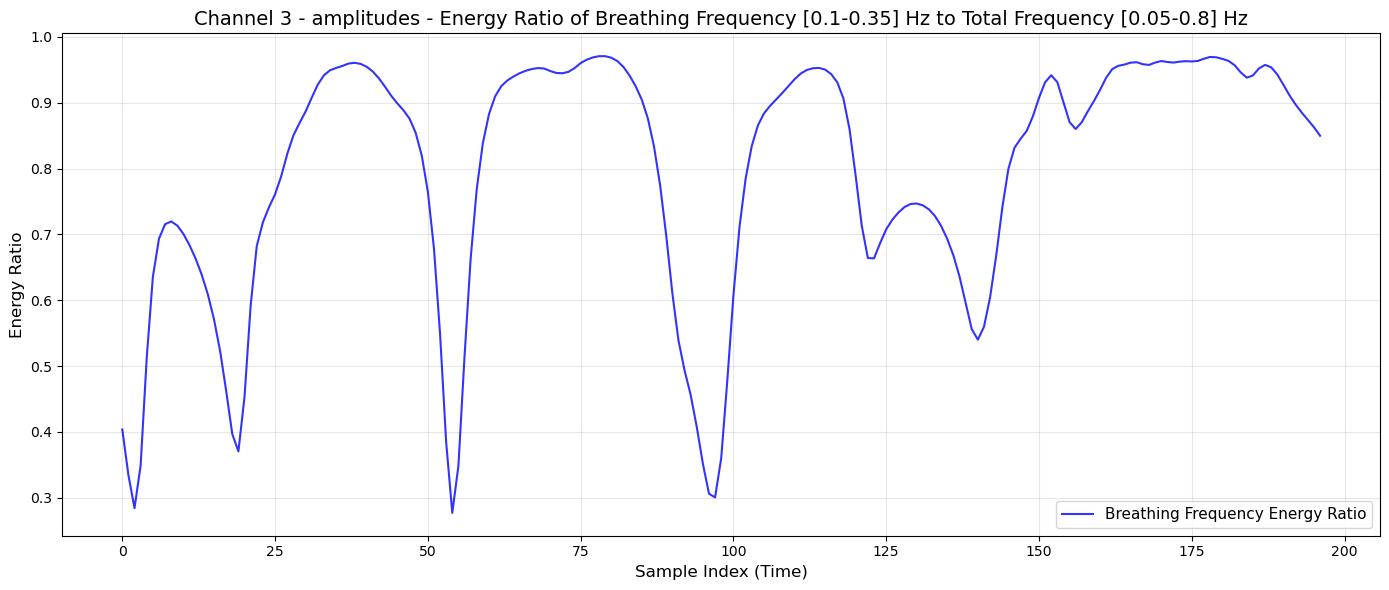


正在收集所有信道的能量占比数据（变量: amplitudes）...
✓ 找到 1 个有效信道
时间窗数量范围: 197 - 197


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\303887569.py:224: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20')  # 使用tab20 colormap，支持20种不同颜色


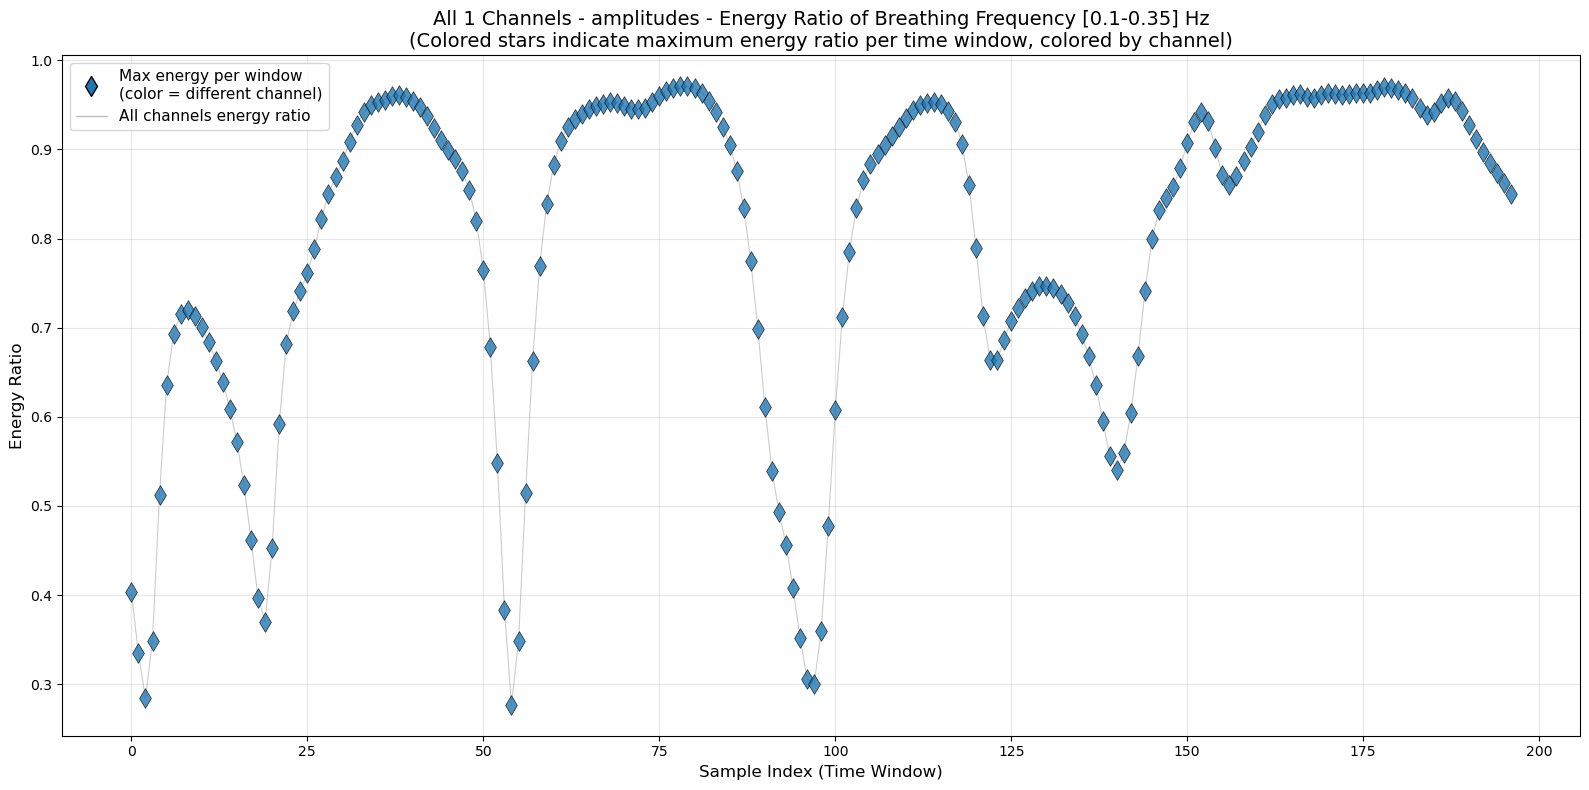


=== 所有信道能量占比统计（变量: amplitudes）===
有效信道数: 1
时间窗数量: 197

作为能量占比最大的次数最多的前10个信道:
信道       次数       占比        
------------------------------
3        197      100.00    %


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\303887569.py:365: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_pool = cm.get_cmap('tab20').colors


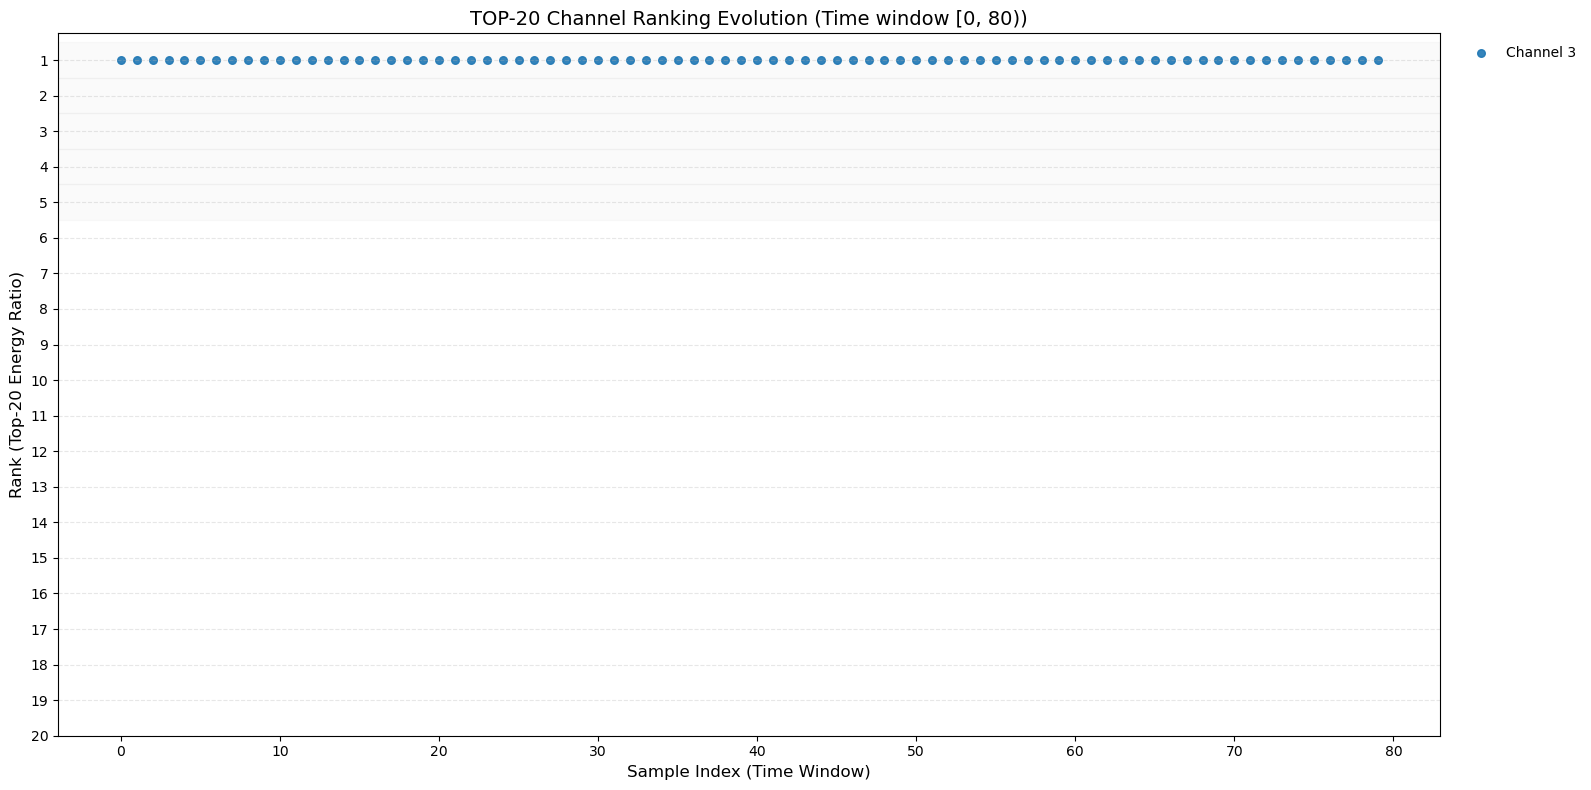

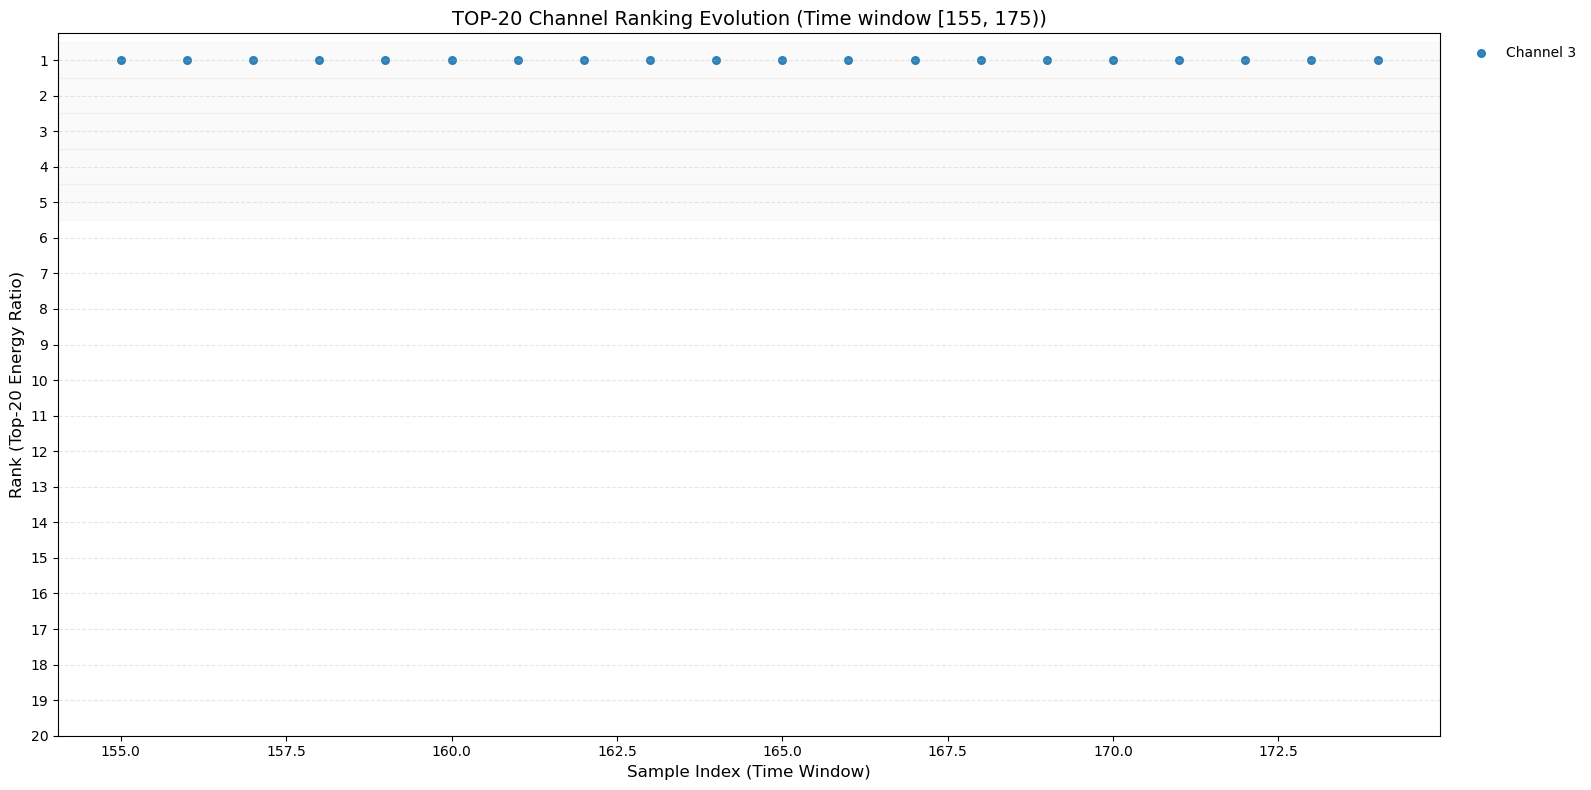

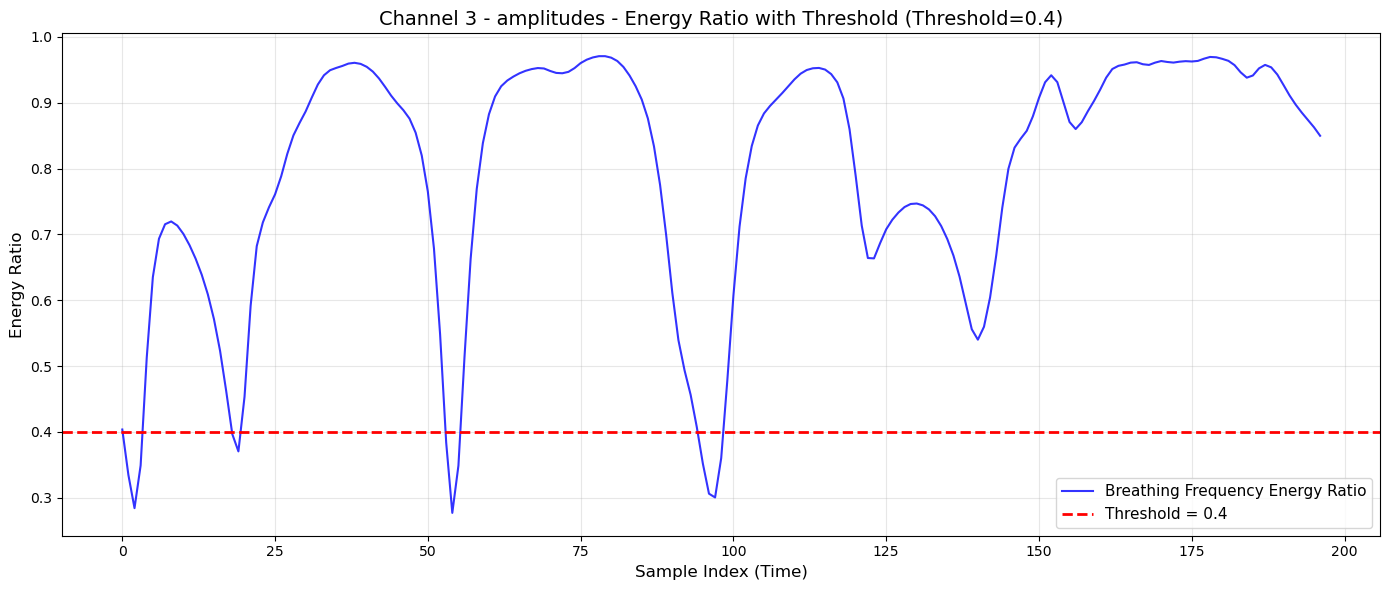


=== 阈值分析（阈值=0.4，仅用于 amplitudes）===
阈值以上的样本数: 185 / 197 (93.9%)
阈值以下的样本数: 12 / 197 (6.1%)


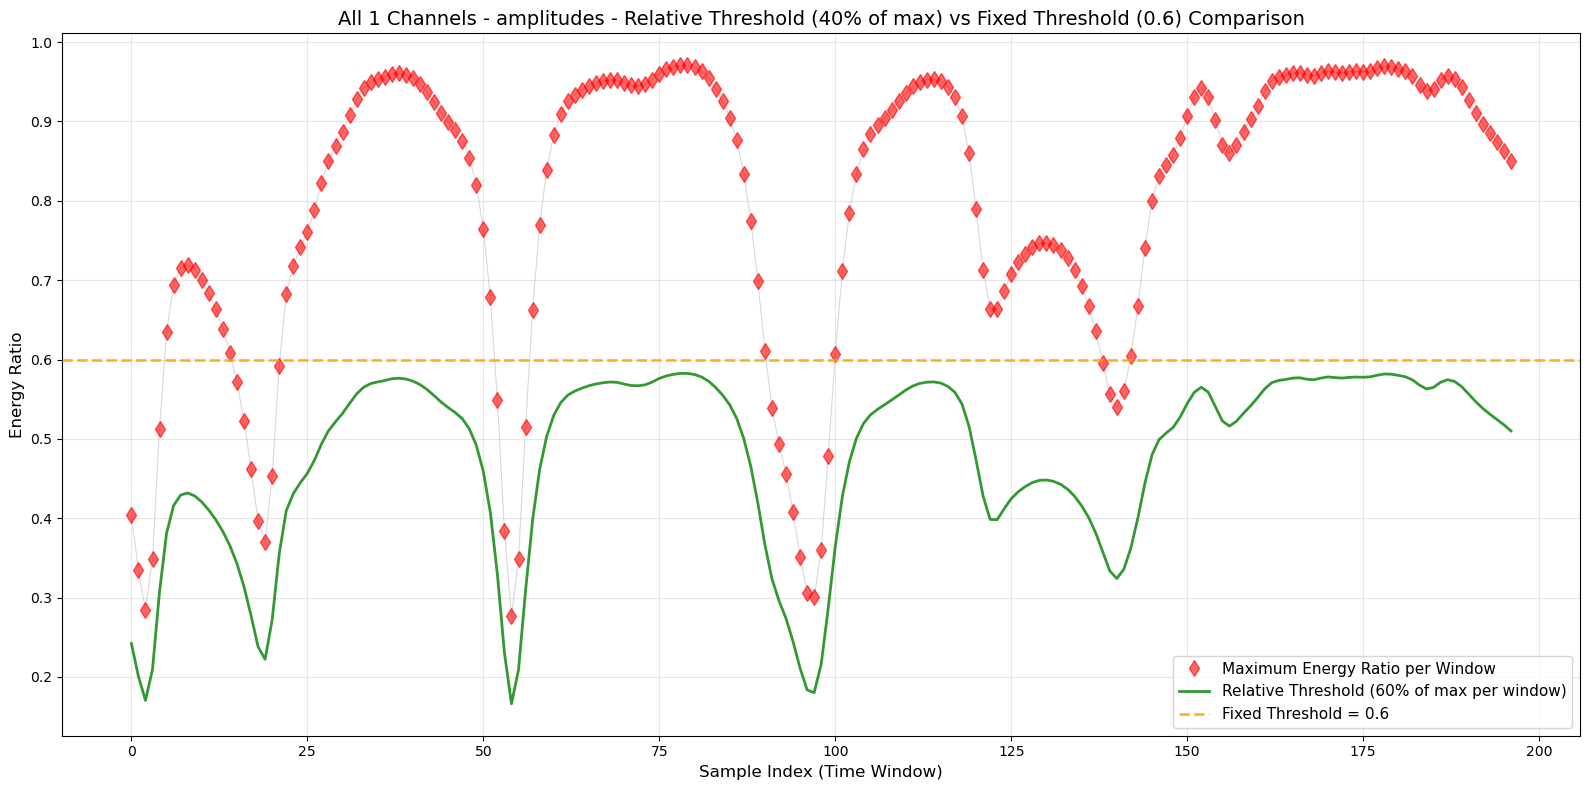


=== 相对阈值 vs 固定阈值对比分析 ===
相对阈值: 每个时间窗最大值的60%
固定阈值: 0.6

按时间窗统计（每个时间窗至少有一个信道超过阈值）:
  相对阈值: 197 / 197 个时间窗 (100.0%)
  固定阈值: 167 / 197 个时间窗 (84.8%)

按所有信道-时间窗组合统计:
  相对阈值: 197 / 197 个样本 (100.0%)
  固定阈值: 167 / 197 个样本 (84.8%)

相对阈值统计:
  平均值: 0.4794
  范围: [0.1662, 0.5825]
  固定阈值: 0.6000


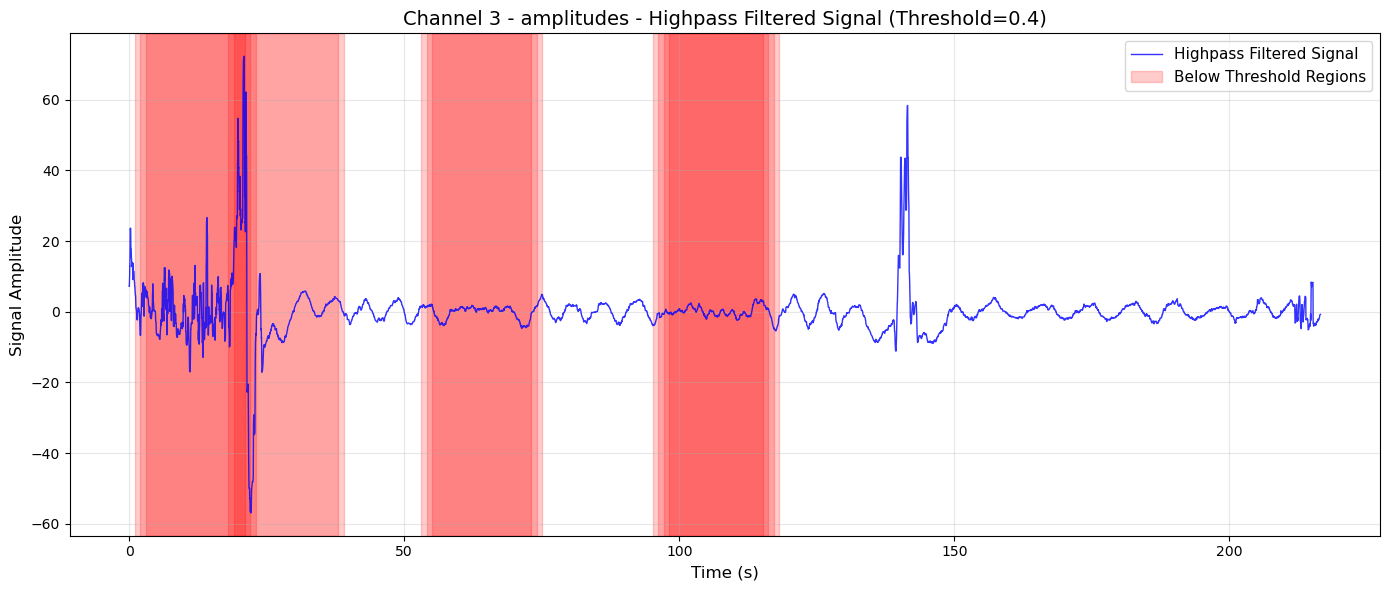

In [15]:
# 15-20秒时间窗，窗内计算呼吸【0.15-0.35】Hz这一范围占所有频率的能量比例
# 所有频率指【0.05-0.8】Hz,或着是上限设置为1/2 fs(2Hz)都可以。

# 参数设置
sampling_rate = 50.0  # Hz
window_length_sec = 20  # 时间窗长度（秒）
step_length_sec = 1  # 步长（秒）
window_length_samples = int(window_length_sec * sampling_rate)  # 20秒 = 40个样本点
step_length_samples = int(step_length_sec * sampling_rate)  # 1秒 = 2个样本点

# 呼吸频率范围
breath_freq_low = 0.1  # Hz
breath_freq_high = 0.35  # Hz
total_freq_low = 0.05  # Hz
total_freq_high = 0.8  # Hz

# # 选择通道和变量（用于展示）
# demo_channel = 0
# demo_variable = 'amplitudes'

# # 如果通道0不存在，使用第一个可用通道
# if demo_channel not in detrended_data and len(detrended_data) > 0:
#     demo_channel = list(detrended_data.keys())[0]
#     print(f"通道0不存在，使用通道 {demo_channel}")

# 存储所有通道和所有变量的分析结果
breathing_analysis_results = {}

# 遍历所有通道和所有变量，进行加窗和能量计算
print("开始对所有通道和所有变量进行加窗和能量计算...")
total_channels = len(detrended_data)
processed_channels = 0

for ch in detrended_data:
    breathing_analysis_results[ch] = {}
    ch_detrended = detrended_data[ch]
    
    # 遍历所有变量
    for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes', 'local_phases', 'remote_phases']:
        if var_name in ch_detrended and 'detrended_order2' in ch_detrended[var_name]:
            # 获取高通滤波后的数据（使用order2）
            filtered_signal = ch_detrended[var_name]['detrended_order2']
            signal_length = len(filtered_signal)
            
            if signal_length < window_length_samples:
                # 信号太短，跳过
                continue
            
            # 对信号进行时间窗分割
            windowed_samples = []
            sample_indices = []
            
            start_idx = 0
            while start_idx + window_length_samples <= signal_length:
                # 提取一个时间窗
                window_data = filtered_signal[start_idx:start_idx + window_length_samples]
                
                # 应用Hanning窗
                hanning_window = np.hanning(len(window_data))
                windowed_data = window_data * hanning_window
                
                # 存储加窗后的样本
                windowed_samples.append(windowed_data)
                sample_indices.append(start_idx)
                
                # 移动到下一个窗口（步长为1秒）
                start_idx += step_length_samples
            
            # 对每个样本进行FFT并计算能量比例
            energy_ratios = []
            
            for i, windowed_data in enumerate(windowed_samples):
                # 计算FFT（使用rfft只计算正频率部分，更高效）
                fft_values = np.fft.rfft(windowed_data)
                fft_power = np.abs(fft_values) ** 2  # 功率谱
                
                # 计算频率轴（只包含正频率）
                fft_freq = np.fft.rfftfreq(len(windowed_data), 1.0 / sampling_rate)
                
                # 找到呼吸频率范围【0.15-0.35】Hz的索引
                breath_mask = (fft_freq >= breath_freq_low) & (fft_freq <= breath_freq_high)
                
                # 找到总频率范围【0.05-0.8】Hz的索引
                total_mask = (fft_freq >= total_freq_low) & (fft_freq <= total_freq_high)
                
                # 计算能量
                breath_energy = np.sum(fft_power[breath_mask])
                total_energy = np.sum(fft_power[total_mask])
                
                # 计算能量比例
                if total_energy > 0:
                    energy_ratio = breath_energy / total_energy
                else:
                    energy_ratio = 0.0
                
                energy_ratios.append(energy_ratio)
            
            # 存储该通道该变量的分析结果
            breathing_analysis_results[ch][var_name] = {
                'energy_ratios': np.array(energy_ratios),
                'windowed_samples': windowed_samples,
                'sample_indices': sample_indices,
                'filtered_signal': filtered_signal,
                'signal_length': signal_length
            }
    
    processed_channels += 1
    if processed_channels % 10 == 0 or processed_channels == total_channels:
        print(f"  已处理 {processed_channels}/{total_channels} 个通道...")

print(f"✓ 所有通道和变量的加窗和能量计算完成")


# 选择通道和变量（用于展示）
demo_channel = 0
demo_variable = 'amplitudes'

# 如果通道0不存在，使用第一个可用通道
if demo_channel not in detrended_data and len(detrended_data) > 0:
    demo_channel = list(detrended_data.keys())[0]
    print(f"通道0不存在，使用通道 {demo_channel}")
    
# 检查demo_channel和demo_variable的数据是否存在
if demo_channel not in breathing_analysis_results or demo_variable not in breathing_analysis_results[demo_channel]:
    print(f"⚠️ 无法找到通道 {demo_channel} 的变量 {demo_variable}")
else:
    # 获取demo_variable的分析结果
    demo_results = breathing_analysis_results[demo_channel][demo_variable]
    breathing_energy_ratios = demo_results['energy_ratios']
    windowed_samples = demo_results['windowed_samples']
    sample_indices = demo_results['sample_indices']
    filtered_signal = demo_results['filtered_signal']
    signal_length = demo_results['signal_length']
    
    print(f"\n=== 展示通道 {demo_channel} 的变量 {demo_variable} ===")
    print(f"信号长度: {signal_length} 个样本点")
    print(f"时间窗长度: {window_length_sec}秒 ({window_length_samples}个样本点)")
    print(f"步长: {step_length_sec}秒 ({step_length_samples}个样本点)")
    print(f"✓ 共生成 {len(windowed_samples)} 个时间窗样本")
    print(f"✓ 能量比例计算完成，共 {len(breathing_energy_ratios)} 个样本")
    print(f"能量比例范围: [{np.min(breathing_energy_ratios):.4f}, {np.max(breathing_energy_ratios):.4f}]")
    print(f"平均能量比例: {np.mean(breathing_energy_ratios):.4f}")
    
    # 绘制能量占比图
    sample_numbers = np.arange(len(breathing_energy_ratios))
    time_axis = sample_numbers * step_length_sec  # 时间轴（秒）
    
    # 图1：能量占比曲线
    plt.figure(figsize=(14, 6))
    plt.plot(sample_numbers, breathing_energy_ratios, 'b-', linewidth=1.5, alpha=0.8, label='Breathing Frequency Energy Ratio')
    plt.xlabel('Sample Index (Time)', fontsize=12)
    plt.ylabel('Energy Ratio', fontsize=12)
    plt.title(f'Channel {demo_channel} - {demo_variable} - Energy Ratio of Breathing Frequency [{breath_freq_low}-{breath_freq_high}] Hz to Total Frequency [{total_freq_low}-{total_freq_high}] Hz', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    # 图1.5：所有72个信道的能量占比曲线 + 每个时间窗中能量占比最大的信号标记
    # 收集所有信道的能量占比数据（使用demo_variable）
    print(f"\n正在收集所有信道的能量占比数据（变量: {demo_variable}）...")
    all_channels_energy_ratios = {}
    valid_channels = []
    
    for ch in breathing_analysis_results:
        if demo_variable in breathing_analysis_results[ch]:
            energy_ratios = breathing_analysis_results[ch][demo_variable]['energy_ratios']
            all_channels_energy_ratios[ch] = energy_ratios
            valid_channels.append(ch)
    
    print(f"✓ 找到 {len(valid_channels)} 个有效信道")
    
    if len(valid_channels) > 0:
        # 确定所有信道中时间窗数量的最大值（用于对齐）
        max_windows = max(len(all_channels_energy_ratios[ch]) for ch in valid_channels)
        min_windows = min(len(all_channels_energy_ratios[ch]) for ch in valid_channels)
        
        print(f"时间窗数量范围: {min_windows} - {max_windows}")
        
        # 创建图形
        plt.figure(figsize=(16, 8))
        
        # 绘制所有信道的能量占比曲线
        for ch in valid_channels:
            energy_ratios = all_channels_energy_ratios[ch]
            ch_sample_numbers = np.arange(len(energy_ratios))
            plt.plot(ch_sample_numbers, energy_ratios, '-', linewidth=0.8, alpha=0.4, color='gray', label=None)
        
        # 在每个时间窗中找到能量占比最大的信道
        # 使用最小的时间窗数量，确保所有信道都有数据
        max_energy_channels = []  # 存储每个时间窗中能量占比最大的信道
        max_energy_values = []    # 存储每个时间窗中的最大能量占比值
        
        for window_idx in range(min_windows):
            max_energy = -1
            max_ch = None
            
            for ch in valid_channels:
                if window_idx < len(all_channels_energy_ratios[ch]):
                    energy = all_channels_energy_ratios[ch][window_idx]
                    if energy > max_energy:
                        max_energy = energy
                        max_ch = ch
            
            if max_ch is not None:
                max_energy_channels.append(max_ch)
                max_energy_values.append(max_energy)
            else:
                max_energy_channels.append(None)
                max_energy_values.append(0)
        
        # 绘制每个时间窗中能量占比最大的点，根据所属信道使用不同颜色
        max_sample_numbers = np.arange(len(max_energy_values))
        
        # 为每个信道分配颜色（使用colormap）
        import matplotlib.cm as cm
        unique_channels = sorted(set(max_energy_channels))
        if None in unique_channels:
            unique_channels.remove(None)
        n_unique_channels = len(unique_channels)
        
        if n_unique_channels > 0:
            # 使用colormap为每个信道分配颜色
            colormap = cm.get_cmap('tab20')  # 使用tab20 colormap，支持20种不同颜色
            if n_unique_channels > 20:
                colormap = cm.get_cmap('tab20c')  # 如果信道数超过20，使用tab20c（支持更多颜色）
            
            channel_colors = {}
            for idx, ch in enumerate(unique_channels):
                channel_colors[ch] = colormap(idx % colormap.N)
            
            # 按信道分组绘制标记点
            for ch in unique_channels:
                ch_indices = [i for i, max_ch in enumerate(max_energy_channels) if max_ch == ch]
                if ch_indices:
                    ch_x = [max_sample_numbers[i] for i in ch_indices]
                    ch_y = [max_energy_values[i] for i in ch_indices]
                    plt.scatter(ch_x, ch_y, c=[channel_colors[ch]], marker='d', s=100, alpha=0.8, 
                              label=f'Channel {ch}', zorder=10, edgecolors='black', linewidths=0.5)
        
        # 添加图例和标签
        plt.xlabel('Sample Index (Time Window)', fontsize=12)
        plt.ylabel('Energy Ratio', fontsize=12)
        plt.title(f'All {len(valid_channels)} Channels - {demo_variable} - Energy Ratio of Breathing Frequency [{breath_freq_low}-{breath_freq_high}] Hz\n(Colored stars indicate maximum energy ratio per time window, colored by channel)', fontsize=14)
        plt.grid(True, alpha=0.3)
        # plt.legend(fontsize=11)

        from matplotlib.lines import Line2D

        legend_elements = [
            Line2D([0], [0],
                marker='d',
                color='w',
                label='Max energy per window\n(color = different channel)',
                markerfacecolor='tab:blue',
                markeredgecolor='black',
                markersize=10),
            Line2D([0], [0],
                color='gray',
                lw=1,
                alpha=0.5,
                label='All channels energy ratio')
        ]

        plt.legend(handles=legend_elements,
                loc='best',
                fontsize=11,
                frameon=True,)



        plt.tight_layout()
        plt.show()
        
        # 打印统计信息
        print(f"\n=== 所有信道能量占比统计（变量: {demo_variable}）===")
        print(f"有效信道数: {len(valid_channels)}")
        print(f"时间窗数量: {min_windows}")
        
        # 统计每个信道作为最大值的次数
        channel_max_count = {}
        for ch in valid_channels:
            channel_max_count[ch] = 0
        
        for max_ch in max_energy_channels:
            if max_ch is not None:
                channel_max_count[max_ch] = channel_max_count.get(max_ch, 0) + 1
        
        # 找出作为最大值次数最多的前10个信道
        sorted_channels = sorted(channel_max_count.items(), key=lambda x: x[1], reverse=True)
        print(f"\n作为能量占比最大的次数最多的前10个信道:")
        print(f"{'信道':<8} {'次数':<8} {'占比':<10}")
        print("-" * 30)
        for ch, count in sorted_channels[:10]:
            percentage = count / len(max_energy_channels) * 100 if len(max_energy_channels) > 0 else 0
            print(f"{ch:<8} {count:<8} {percentage:<10.2f}%")
    
    # 图 1.5.1 TOP 10 信道变化
    # top_k = 10
    # top_channels = [ch for ch, _ in sorted_channels[:top_k]]
    # # import numpy as np

    # n_windows = len(max_energy_channels)
    # top_index = {ch: i for i, ch in enumerate(top_channels)}

    # # 初始化为 NaN（表示没有赢）
    # winner_matrix = np.full((top_k, n_windows), np.nan)

    # for t, ch in enumerate(max_energy_channels):
    #     if ch in top_index:
    #         winner_matrix[top_index[ch], t] = 1

    # plt.figure(figsize=(16, 4))

    # for i, ch in enumerate(top_channels):
    #     win_times = np.where(~np.isnan(winner_matrix[i]))[0]
    #     plt.scatter(
    #         win_times,
    #         np.full_like(win_times, i),
    #         s=25,
    #         marker='s',
    #         label=f'Channel {ch}'
    #     )

    # plt.yticks(
    #     ticks=range(top_k),
    #     labels=[f'Channel {ch}' for ch in top_channels]
    # )

    # plt.xlabel('Sample Index (Time Window)', fontsize=12)
    # plt.ylabel('Top-10 Channels (ranked)', fontsize=12)
    # plt.title(
    #     'Temporal distribution of TOP-10 channels\n'
    #     '(channel wins per time window)',
    #     fontsize=13
    # )

    # plt.grid(axis='x', alpha=0.2)
    # plt.tight_layout()
    # plt.show()

    # 1.5.2 TOP10排名变化图

    top_k = 20
    rankings = []  # list of dicts: [{channel: rank}, ...]

    for t in range(min_windows):
        window_energy = []

        for ch in valid_channels:
            if t < len(all_channels_energy_ratios[ch]):
                window_energy.append((ch, all_channels_energy_ratios[ch][t]))

        # 按能量从大到小排序
        window_energy.sort(key=lambda x: x[1], reverse=True)

        # 取 TOP‑10
        top = window_energy[:top_k]

        # 记录排名（1 是第一名）
        rankings.append({ch: rank + 1 for rank, (ch, _) in enumerate(top)})

    # import matplotlib.cm as cm

    color_pool = cm.get_cmap('tab20').colors
    channel_color = {}
    color_idx = 0

    def get_color(ch):
        global color_idx
        if ch not in channel_color:
            channel_color[ch] = color_pool[color_idx % len(color_pool)]
            color_idx += 1
        return channel_color[ch]

    # # import numpy as np

    time_axis = np.arange(len(rankings))
    channel_ranks = {}  # ch -> list of rank or NaN

    for t, rank_dict in enumerate(rankings):
        for ch, r in rank_dict.items():
            if ch not in channel_ranks:
                channel_ranks[ch] = [np.nan] * len(rankings)
            channel_ranks[ch][t] = r

    last_ranking = rankings[-1]
    final_top10 = set(last_ranking.keys())


    # 1.5.3 分段排名变化

    def plot_bump_segment(
        rankings,
        channel_ranks,
        start,
        end,
        title_suffix
    ):
        plt.figure(figsize=(16, 8))

        # 当前时间段
        time_seg = np.arange(start, end)

        # 当前段最后一帧的 TOP-10（决定 legend）
        final_ranking = rankings[end - 1]
        final_top10 = set(final_ranking.keys())

        for ch, ranks in channel_ranks.items():
            seg_ranks = np.array(ranks[start:end])

            if np.all(np.isnan(seg_ranks)):
                continue

            color = get_color(ch)

            label = f'Channel {ch}' if ch in final_top10 else None

            # plt.plot(
            #     time_seg,
            #     seg_ranks,
            #     '-o',
            #     linewidth=2,
            #     markersize=4,
            #     alpha=0.85 if ch in final_top10 else 0.25,
            #     color=color,
            #     label=label
            # )
            # plt.scatter(
            #     time_seg,
            #     seg_ranks,
            #     s=25,
            #     alpha=0.85 if ch in final_top10 else 0.25,
            #     color=color,
            #     label=label
            # )
            highlight = ch in final_top10

            plt.scatter(
                time_seg,
                seg_ranks,
                s=30,
                alpha=0.9 if highlight else 0.15,
                color=color if highlight else 'lightgray',
                label=label
            )
            for r in range(1, 6):  # 只强调前 5 名
                plt.axhspan(r - 0.5, r + 0.5,
                            color='gray',
                            alpha=0.04,
                            zorder=0)

        plt.gca().invert_yaxis()
        plt.yticks(range(1, top_k + 1))
        plt.xlabel('Sample Index (Time Window)', fontsize=12)
        plt.ylabel(f'Rank (Top-{top_k} Energy Ratio)', fontsize=12)
        plt.title(
            f'TOP-{top_k} Channel Ranking Evolution ({title_suffix})',
            fontsize=14
        )

        plt.grid(True, axis='y', linestyle='--', alpha=0.3)
        plt.legend(
            loc='upper left',
            bbox_to_anchor=(1.01, 1),
            fontsize=10,
            frameon=False
        )

        plt.tight_layout()
        plt.show()

    start = 0
    end = 80
    end_safe = min(end, len(rankings))
    title_suffix = f'Time window [{start}, {end_safe})'
    plot_bump_segment(
        rankings,
        channel_ranks,
        start=start,
        end=end_safe,
        title_suffix=title_suffix
    )
    start=155
    end = 175
    end_safe = min(end, len(rankings))
    title_suffix = f'Time window [{start}, {end_safe})'
    plot_bump_segment(
        rankings,
        channel_ranks,
        start=start,
        end=end_safe,
        title_suffix=title_suffix
    )

    # 手动指定阈值（只用于demo_variable）
    threshold = 0.4
    
    # 图2：能量占比曲线 + 阈值线
    plt.figure(figsize=(14, 6))
    plt.plot(sample_numbers, breathing_energy_ratios, 'b-', linewidth=1.5, alpha=0.8, label='Breathing Frequency Energy Ratio')
    plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('Sample Index (Time)', fontsize=12)
    plt.ylabel('Energy Ratio', fontsize=12)
    plt.title(f'Channel {demo_channel} - {demo_variable} - Energy Ratio with Threshold (Threshold={threshold})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    # 统计阈值以上的样本数量
    above_threshold = np.sum(breathing_energy_ratios >= threshold)
    below_threshold = len(breathing_energy_ratios) - above_threshold
    
    print(f"\n=== 阈值分析（阈值={threshold}，仅用于 {demo_variable}）===")
    print(f"阈值以上的样本数: {above_threshold} / {len(breathing_energy_ratios)} ({above_threshold/len(breathing_energy_ratios)*100:.1f}%)")
    print(f"阈值以下的样本数: {below_threshold} / {len(breathing_energy_ratios)} ({below_threshold/len(breathing_energy_ratios)*100:.1f}%)")
    
    # 图2.5：相对阈值（40%最大能量值）vs 固定阈值（0.6）对比
    # 使用所有信道的最大能量值来计算相对阈值
    # 如果图1.5已经计算了这些变量，直接使用；否则重新计算
    if len(valid_channels) > 0:
        # 检查是否已经计算了max_energy_values
        if 'max_energy_values' not in locals() or len(max_energy_values) == 0:
            # 重新计算max_energy_values
            if 'min_windows' not in locals():
                min_windows = min(len(all_channels_energy_ratios[ch]) for ch in valid_channels)
            
            max_energy_values = []
            for window_idx in range(min_windows):
                max_energy = -1
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        energy = all_channels_energy_ratios[ch][window_idx]
                        if energy > max_energy:
                            max_energy = energy
                max_energy_values.append(max_energy if max_energy > 0 else 0)
        
        if len(max_energy_values) > 0:
            # 计算相对阈值：每个时间窗最大值的百分比%
            relative_threshold_ratio = 0.6
            relative_thresholds = [max_val * relative_threshold_ratio for max_val in max_energy_values]
            
            # 创建图形
            plt.figure(figsize=(16, 8))
            
            # 绘制所有信道的能量占比曲线（灰色背景）
            for ch in valid_channels:
                energy_ratios = all_channels_energy_ratios[ch]
                ch_sample_numbers = np.arange(len(energy_ratios))
                plt.plot(ch_sample_numbers, energy_ratios, '-', linewidth=0.8, alpha=0.3, color='gray', label=None)
            
            # 绘制每个时间窗的最大能量值（红色星号）
            max_sample_numbers = np.arange(len(max_energy_values))
            plt.plot(max_sample_numbers, max_energy_values, 'rd', markersize=8, alpha=0.6, 
                    label=f'Maximum Energy Ratio per Window', zorder=5)
            
            # 绘制相对阈值线（每个时间窗最大值的X0%）
            plt.plot(max_sample_numbers, relative_thresholds, 'g-', linewidth=2, alpha=0.8, 
                    label=f'Relative Threshold ({relative_threshold_ratio*100:.0f}% of max per window)', zorder=6)
            
            # 绘制固定阈值线（0.6）
            fixed_threshold = 0.6
            plt.axhline(y=fixed_threshold, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
                    label=f'Fixed Threshold = {fixed_threshold}', zorder=7)
            
            # 添加图例和标签
            plt.xlabel('Sample Index (Time Window)', fontsize=12)
            plt.ylabel('Energy Ratio', fontsize=12)
            plt.title(f'All {len(valid_channels)} Channels - {demo_variable} - Relative Threshold (40% of max) vs Fixed Threshold (0.6) Comparison', fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=11, loc='best')
            plt.tight_layout()
            plt.show()
        
            # 统计两种阈值下的样本数量
            # 对于相对阈值，需要检查每个时间窗中是否有信道超过该时间窗的相对阈值
            # 对于固定阈值，检查每个时间窗中是否有信道超过固定阈值
            relative_above_count = 0
            fixed_above_count = 0
            total_windows = len(max_energy_values)
            
            for window_idx in range(min_windows):
                # 检查该时间窗中是否有信道超过相对阈值
                relative_thresh = relative_thresholds[window_idx]
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        if all_channels_energy_ratios[ch][window_idx] >= relative_thresh:
                            relative_above_count += 1
                            break  # 只要有一个信道超过就计数
                
                # 检查该时间窗中是否有信道超过固定阈值
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        if all_channels_energy_ratios[ch][window_idx] >= fixed_threshold:
                            fixed_above_count += 1
                            break  # 只要有一个信道超过就计数
            
            # 另一种统计方式：统计所有信道-时间窗组合中超过阈值的数量
            relative_above_all = 0
            fixed_above_all = 0
            total_samples = 0
            
            for window_idx in range(min_windows):
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        total_samples += 1
                        energy = all_channels_energy_ratios[ch][window_idx]
                        if energy >= relative_thresholds[window_idx]:
                            relative_above_all += 1
                        if energy >= fixed_threshold:
                            fixed_above_all += 1
            
            print(f"\n=== 相对阈值 vs 固定阈值对比分析 ===")
            print(f"相对阈值: 每个时间窗最大值的{relative_threshold_ratio*100:.0f}%")
            print(f"固定阈值: {fixed_threshold}")
            print(f"\n按时间窗统计（每个时间窗至少有一个信道超过阈值）:")
            print(f"  相对阈值: {relative_above_count} / {total_windows} 个时间窗 ({relative_above_count/total_windows*100:.1f}%)")
            print(f"  固定阈值: {fixed_above_count} / {total_windows} 个时间窗 ({fixed_above_count/total_windows*100:.1f}%)")
            print(f"\n按所有信道-时间窗组合统计:")
            print(f"  相对阈值: {relative_above_all} / {total_samples} 个样本 ({relative_above_all/total_samples*100:.1f}%)")
            print(f"  固定阈值: {fixed_above_all} / {total_samples} 个样本 ({fixed_above_all/total_samples*100:.1f}%)")
            
            # 计算相对阈值的平均值和范围
            avg_relative_threshold = np.mean(relative_thresholds)
            min_relative_threshold = np.min(relative_thresholds)
            max_relative_threshold = np.max(relative_thresholds)
            print(f"\n相对阈值统计:")
            print(f"  平均值: {avg_relative_threshold:.4f}")
            print(f"  范围: [{min_relative_threshold:.4f}, {max_relative_threshold:.4f}]")
            print(f"  固定阈值: {fixed_threshold:.4f}")
    
    # 图3：高通滤波后的信号 + 低于阈值的区间背景标记
    # 获取时间轴
    timestamps_ms = all_channels_data[demo_channel]['timestamps_ms']
    if len(timestamps_ms) > 0:
        time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0
    else:
        time_sec = np.arange(len(filtered_signal)) / sampling_rate
    
    # 确保时间轴长度与信号长度匹配
    if len(time_sec) != len(filtered_signal):
        time_sec = np.arange(len(filtered_signal)) / sampling_rate
    
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    
    # 绘制高通滤波后的信号
    ax.plot(time_sec, filtered_signal, 'b-', linewidth=1.0, alpha=0.8, label='Highpass Filtered Signal')
    
    # 标记低于阈值的区间
    # 找到所有低于阈值的样本
    below_threshold_samples = np.where(breathing_energy_ratios < threshold)[0]
    
    # 为每个低于阈值的样本绘制背景区域
    label_added = False
    for sample_idx in below_threshold_samples:
        # 使用sample_indices获取该样本的起始索引
        if sample_idx < len(sample_indices):
            start_idx = sample_indices[sample_idx]
            end_idx = start_idx + window_length_samples
            
            # 确保索引在有效范围内
            if end_idx <= len(time_sec):
                start_time = time_sec[start_idx]
                end_time = time_sec[end_idx - 1] if end_idx > 0 else time_sec[-1]
            else:
                # 如果超出范围，使用最后一个时间点
                start_time = time_sec[start_idx] if start_idx < len(time_sec) else time_sec[-1]
                end_time = time_sec[-1]
        else:
            # 如果sample_indices不可用，使用近似计算
            start_time = sample_idx * step_length_sec
            end_time = start_time + window_length_sec
            start_time = max(start_time, time_sec[0])
            end_time = min(end_time, time_sec[-1])
        
        # 绘制浅红色背景区域
        if not label_added:
            ax.axvspan(start_time, end_time, alpha=0.2, color='red', label='Below Threshold Regions')
            label_added = True
        else:
            ax.axvspan(start_time, end_time, alpha=0.2, color='red')
    
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Signal Amplitude', fontsize=12)
    ax.set_title(f'Channel {demo_channel} - {demo_variable} - Highpass Filtered Signal (Threshold={threshold})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


# add.3 带通滤波
保留呼吸
- 通带：
  - **0.15 – 0.35 Hz**
  - 0.15稍大，换0.1
- 阶数：
  - **2 阶 Butterworth**
- 滤波方式：
  - 零相位

✓ Using bandpass_filter_zero_phase from utils.signal_algrithom

Applying bandpass filter to windowed data...
Sampling rate: 50.0 Hz
Passband: 0.1 - 0.35 Hz
Threshold for energy ratio: 0.6
开始对所有通道和所有变量进行带通滤波...
已处理 1/1 个通道...
✓ Bandpass filtering and frequency estimation completed for all channels and variables
通道0不存在，使用通道 3


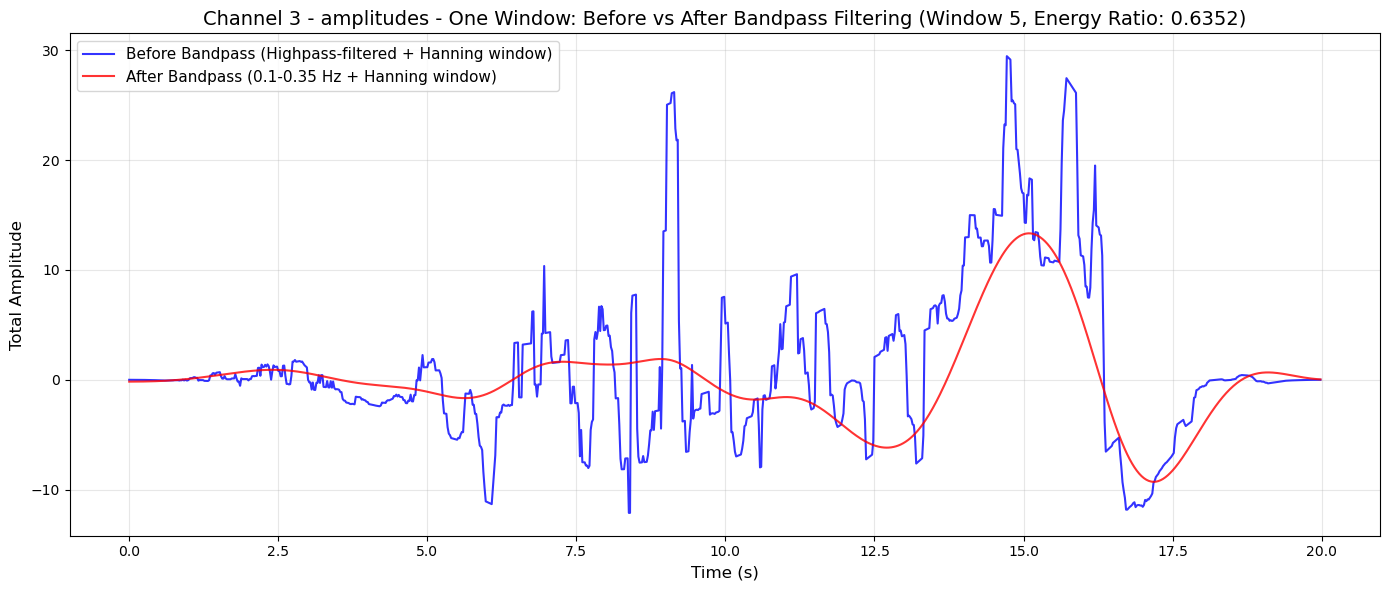

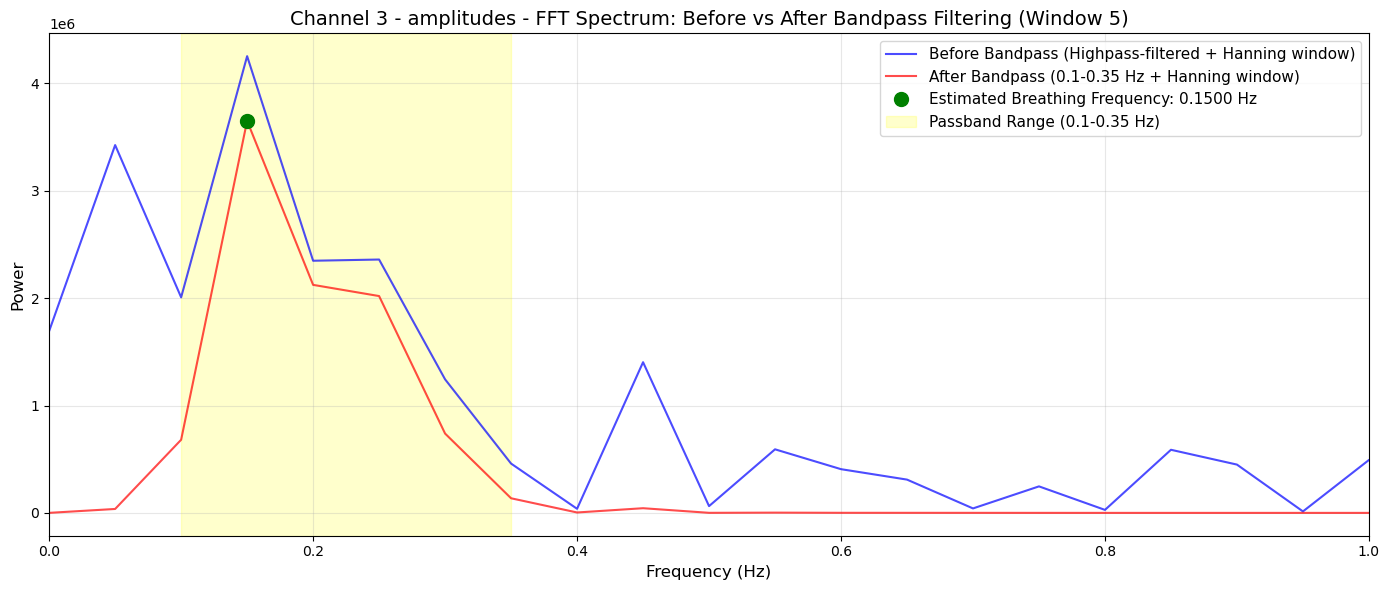

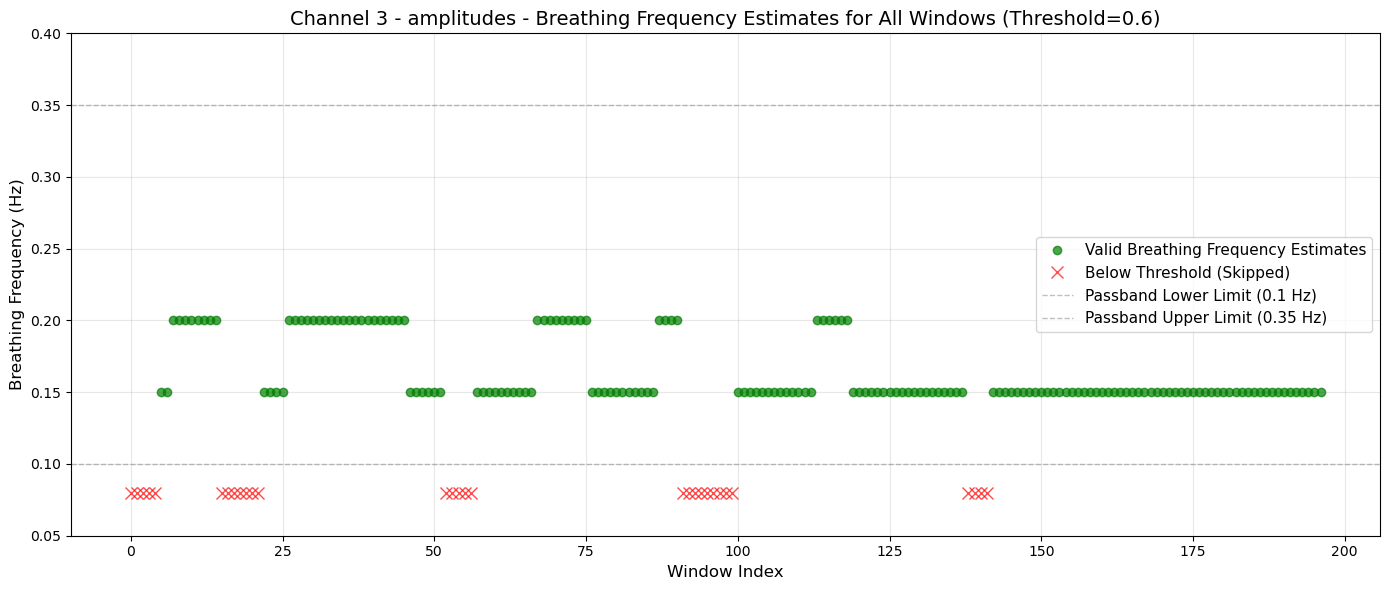


=== Channel 3 - Total Amplitude - Breathing Frequency Statistics ===
Total windows: 197
Valid windows (above threshold): 167 (84.8%)
Invalid windows (below threshold): 30 (15.2%)

Valid breathing frequency estimates:
  Mean: 0.1641 Hz
  Std: 0.0225 Hz
  Min: 0.1500 Hz
  Max: 0.2000 Hz


In [16]:
# Apply bandpass filter to windowed data (only for windows with energy ratio above threshold)
# Use the windowed data from breathing_analysis_results

# Import bandpass filter function from utils
try:
    from utils.signal_algrithom import bandpass_filter_zero_phase
    print("✓ Using bandpass_filter_zero_phase from utils.signal_algrithom")
except ImportError:
    print("⚠️ Import failed, using sig_algm")

# Parameters
sampling_rate = 50.0  # Hz (2 Hz sampling rate as mentioned)
lowcut = 0.1  # Hz (low cutoff frequency for breathing range)
highcut = 0.35  # Hz (high cutoff frequency for breathing range)
threshold = 0.6  # Same threshold as used in breathing detection

print(f"\nApplying bandpass filter to windowed data...")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Passband: {lowcut} - {highcut} Hz")
print(f"Threshold for energy ratio: {threshold}")

# Check if breathing_analysis_results exists
if 'breathing_analysis_results' not in globals():
    print("⚠️ breathing_analysis_results not found. Please run the breathing detection section first.")
else:
    # Store bandpass filtered results and breathing frequency estimates
    bandpass_results = {}
    breathing_freq_estimates = {}
    
    # Process all channels and variables
    print("开始对所有通道和所有变量进行带通滤波...")
    total_channels = len(detrended_data)
    processed_channels = 0
    for ch in breathing_analysis_results:
        bandpass_results[ch] = {}
        breathing_freq_estimates[ch] = {}
        
        for var_name in breathing_analysis_results[ch]:
            energy_ratios = breathing_analysis_results[ch][var_name]['energy_ratios']
            windowed_samples = breathing_analysis_results[ch][var_name]['windowed_samples']
            
            # Apply bandpass filter to each window (only if energy ratio >= threshold)
            bandpass_filtered_windows = []
            breathing_freqs = []  # Store breathing frequency estimates for each window
            
            for i, (windowed_data, energy_ratio) in enumerate(zip(windowed_samples, energy_ratios)):
                if energy_ratio >= threshold:
                    # Apply bandpass filter directly to the windowed data
                    # Note: windowed_data is already windowed with Hanning window
                    # We apply bandpass filter to the windowed data
                    bandpass_windowed = sig_algm.bandpass_filter_zero_phase(
                        windowed_data,
                        lowcut=lowcut,
                        highcut=highcut,
                        sampling_rate=sampling_rate,
                        order=2
                    )
                    
                    bandpass_filtered_windows.append(bandpass_windowed)
                    
                    # Use FFT to estimate breathing frequency (find frequency with maximum energy)
                    fft_values = np.fft.rfft(bandpass_windowed)
                    fft_power = np.abs(fft_values) ** 2
                    fft_freq = np.fft.rfftfreq(len(bandpass_windowed), 1.0 / sampling_rate)
                    
                    # Find frequency range within [lowcut, highcut]
                    freq_mask = (fft_freq >= lowcut) & (fft_freq <= highcut)
                    if np.any(freq_mask):
                        # Find frequency with maximum power in the passband
                        max_power_idx = np.argmax(fft_power[freq_mask])
                        # Get the actual index in fft_freq
                        freq_indices = np.where(freq_mask)[0]
                        max_freq_idx = freq_indices[max_power_idx]
                        breathing_freq = fft_freq[max_freq_idx]
                    else:
                        breathing_freq = np.nan
                    
                    breathing_freqs.append(breathing_freq)
                else:
                    # Energy ratio below threshold, skip this window
                    bandpass_filtered_windows.append(None)
                    breathing_freqs.append(np.nan)  # Mark as invalid
            
            bandpass_results[ch][var_name] = {
                'bandpass_filtered_windows': bandpass_filtered_windows,
                'energy_ratios': energy_ratios,
                'sample_indices': breathing_analysis_results[ch][var_name]['sample_indices']
            }
            
            breathing_freq_estimates[ch][var_name] = np.array(breathing_freqs)

        processed_channels += 1
        if processed_channels % 10 == 0 or processed_channels == total_channels:
            print(f"已处理 {processed_channels}/{total_channels} 个通道...")
    
    print(f"✓ Bandpass filtering and frequency estimation completed for all channels and variables")


# Visualize results for demo_variable
# Select a channel and variable for demonstration
demo_channel = 0
demo_variable = 'amplitudes'

# If channel 0 doesn't exist, use the first available channel
if demo_channel not in breathing_analysis_results and len(breathing_analysis_results) > 0:
    demo_channel = list(breathing_analysis_results.keys())[0]
    print(f"通道0不存在，使用通道 {demo_channel}")

if demo_channel in bandpass_results and demo_variable in bandpass_results[demo_channel]:
    # Get data
    bandpass_windows = bandpass_results[demo_channel][demo_variable]['bandpass_filtered_windows']
    energy_ratios = bandpass_results[demo_channel][demo_variable]['energy_ratios']
    sample_indices = bandpass_results[demo_channel][demo_variable]['sample_indices']
    breathing_freqs = breathing_freq_estimates[demo_channel][demo_variable]
    
    # Get original windowed samples (before bandpass)
    original_windowed_samples = breathing_analysis_results[demo_channel][demo_variable]['windowed_samples']
    
    # Variable name mapping
    var_names = {
        'amplitudes': 'Total Amplitude',
        'phases': 'Total Phase',
        'local_amplitudes': 'Local Amplitude',
        'remote_amplitudes': 'Remote Amplitude',
        'local_phases': 'Local Phase',
        'remote_phases': 'Remote Phase'
    }
    var_display_name = var_names.get(demo_variable, demo_variable)
    
    # Find a window with energy ratio above threshold for demonstration
    demo_window_idx = None
    for i, (energy_ratio, bp_window) in enumerate(zip(energy_ratios, bandpass_windows)):
        if energy_ratio >= threshold and bp_window is not None:
            demo_window_idx = i
            break
    
    # Plot 1: One window - before and after bandpass filtering
    if demo_window_idx is not None:
        original_window = original_windowed_samples[demo_window_idx]
        bandpass_window = bandpass_windows[demo_window_idx]
        
        # Create time axis for this window
        window_time = np.arange(len(original_window)) / sampling_rate
        
        plt.figure(figsize=(14, 6))
        plt.plot(window_time, original_window, 'b-', linewidth=1.5, alpha=0.8, label='Before Bandpass (Highpass-filtered + Hanning window)')
        plt.plot(window_time, bandpass_window, 'r-', linewidth=1.5, alpha=0.8, label=f'After Bandpass ({lowcut}-{highcut} Hz + Hanning window)')
        plt.xlabel('Time (s)', fontsize=12)
        plt.ylabel(var_display_name, fontsize=12)
        plt.title(f'Channel {demo_channel} - {demo_variable} - One Window: Before vs After Bandpass Filtering (Window {demo_window_idx}, Energy Ratio: {energy_ratios[demo_window_idx]:.4f})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No window found with energy ratio above threshold for demonstration")
    
    # Plot 2: FFT spectrum of one window (before and after bandpass)
    if demo_window_idx is not None:
        original_window = original_windowed_samples[demo_window_idx]
        bandpass_window = bandpass_windows[demo_window_idx]
        
        # Compute FFT for original window (before bandpass)
        fft_original = np.fft.rfft(original_window)
        fft_power_original = np.abs(fft_original) ** 2
        fft_freq_original = np.fft.rfftfreq(len(original_window), 1.0 / sampling_rate)
        
        # Compute FFT for bandpass window (after bandpass)
        fft_bandpass = np.fft.rfft(bandpass_window)
        fft_power_bandpass = np.abs(fft_bandpass) ** 2
        fft_freq_bandpass = np.fft.rfftfreq(len(bandpass_window), 1.0 / sampling_rate)
        
        # Find the estimated breathing frequency for this window
        estimated_freq = breathing_freqs[demo_window_idx]
        
        plt.figure(figsize=(14, 6))
        plt.plot(fft_freq_original, fft_power_original, 'b-', linewidth=1.5, alpha=0.7, label='Before Bandpass (Highpass-filtered + Hanning window)')
        plt.plot(fft_freq_bandpass, fft_power_bandpass, 'r-', linewidth=1.5, alpha=0.7, label=f'After Bandpass ({lowcut}-{highcut} Hz + Hanning window)')
        
        # Mark the estimated breathing frequency
        if not np.isnan(estimated_freq):
            # Find the power at estimated frequency
            freq_idx = np.argmin(np.abs(fft_freq_bandpass - estimated_freq))
            power_at_freq = fft_power_bandpass[freq_idx]
            plt.plot(estimated_freq, power_at_freq, 'go', markersize=10, label=f'Estimated Breathing Frequency: {estimated_freq:.4f} Hz')
        
        # Mark passband range
        plt.axvspan(lowcut, highcut, alpha=0.2, color='yellow', label=f'Passband Range ({lowcut}-{highcut} Hz)')
        
        plt.xlabel('Frequency (Hz)', fontsize=12)
        plt.ylabel('Power', fontsize=12)
        plt.title(f'Channel {demo_channel} - {demo_variable} - FFT Spectrum: Before vs After Bandpass Filtering (Window {demo_window_idx})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.xlim([0, 1.0])  # Focus on frequency range up to 1 Hz
        plt.tight_layout()
        plt.show()
    
    # Plot 3: Breathing frequency estimates for all windows
    sample_numbers = np.arange(len(breathing_freqs))
    valid_mask = ~np.isnan(breathing_freqs)
    invalid_mask = np.isnan(breathing_freqs)
    
    plt.figure(figsize=(14, 6))
    
    # Plot valid frequency estimates
    if np.any(valid_mask):
        plt.plot(sample_numbers[valid_mask], breathing_freqs[valid_mask], 'go', markersize=6, alpha=0.7, label='Valid Breathing Frequency Estimates')
    
    # Mark invalid windows (below threshold)
    if np.any(invalid_mask):
        plt.plot(sample_numbers[invalid_mask], [lowcut-0.02] * np.sum(invalid_mask), 'rx', markersize=8, alpha=0.7, label='Below Threshold (Skipped)')
    
    plt.axhline(y=lowcut, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Passband Lower Limit ({lowcut} Hz)')
    plt.axhline(y=highcut, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Passband Upper Limit ({highcut} Hz)')
    plt.xlabel('Window Index', fontsize=12)
    plt.ylabel('Breathing Frequency (Hz)', fontsize=12)
    plt.title(f'Channel {demo_channel} - {demo_variable} - Breathing Frequency Estimates for All Windows (Threshold={threshold})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.ylim([lowcut - 0.05, highcut + 0.05])
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    valid_freqs = breathing_freqs[valid_mask]
    if len(valid_freqs) > 0:
        print(f"\n=== Channel {demo_channel} - {var_display_name} - Breathing Frequency Statistics ===")
        print(f"Total windows: {len(breathing_freqs)}")
        print(f"Valid windows (above threshold): {np.sum(valid_mask)} ({np.sum(valid_mask)/len(breathing_freqs)*100:.1f}%)")
        print(f"Invalid windows (below threshold): {np.sum(invalid_mask)} ({np.sum(invalid_mask)/len(breathing_freqs)*100:.1f}%)")
        print(f"\nValid breathing frequency estimates:")
        print(f"  Mean: {np.mean(valid_freqs):.4f} Hz")
        print(f"  Std: {np.std(valid_freqs):.4f} Hz")
        print(f"  Min: {np.min(valid_freqs):.4f} Hz")
        print(f"  Max: {np.max(valid_freqs):.4f} Hz")
    else:
        print(f"\n⚠️ No valid breathing frequency estimates found (all windows below threshold)")
else:
    print(f"⚠️ Cannot find channel {demo_channel} variable {demo_variable} in bandpass_results")


## 6. 统计分析


In [17]:
# 计算统计信息
if len(amplitudes) > 0:
    print(f"=== 通道 {channel} 统计信息 ===")
    print(f"\n幅值统计:")
    print(f"  均值: {np.mean(amplitudes):.2f}")
    print(f"  标准差: {np.std(amplitudes):.2f}")
    print(f"  最大值: {np.max(amplitudes):.2f}")
    print(f"  最小值: {np.min(amplitudes):.2f}")
    print(f"  中位数: {np.median(amplitudes):.2f}")
    
    print(f"\n相位统计:")
    print(f"  均值: {np.mean(phases):.4f} rad ({np.degrees(np.mean(phases)):.2f}°)")
    print(f"  标准差: {np.std(phases):.4f} rad ({np.degrees(np.std(phases)):.2f}°)")
    print(f"  最大值: {np.max(phases):.4f} rad ({np.degrees(np.max(phases)):.2f}°)")
    print(f"  最小值: {np.min(phases):.4f} rad ({np.degrees(np.min(phases)):.2f}°)")
    
    print(f"\nLocal幅值统计:")
    print(f"  均值: {np.mean(local_amplitudes):.2f}")
    print(f"  标准差: {np.std(local_amplitudes):.2f}")
    
    print(f"\nRemote幅值统计:")
    print(f"  均值: {np.mean(remote_amplitudes):.2f}")
    print(f"  标准差: {np.std(remote_amplitudes):.2f}")
else:
    print("⚠️  无法计算统计信息: 没有数据")


=== 通道 3 统计信息 ===

幅值统计:
  均值: 69.98
  标准差: 24.26
  最大值: 181.02
  最小值: 36.67
  中位数: 66.78

相位统计:
  均值: 0.0000 rad (0.00°)
  标准差: 0.0000 rad (0.00°)
  最大值: 0.0000 rad (0.00°)
  最小值: 0.0000 rad (0.00°)

Local幅值统计:
  均值: 69.98
  标准差: 24.26

Remote幅值统计:
  均值: 0.00
  标准差: 0.00


## 7. 频率分析（FFT）

使用FFT分析信号的频率成分。


采样率: 49.88 Hz
采样间隔: 0.020 秒

主频率: 0.0046 Hz (0.28 次/分钟)
主频率功率: 19815.37


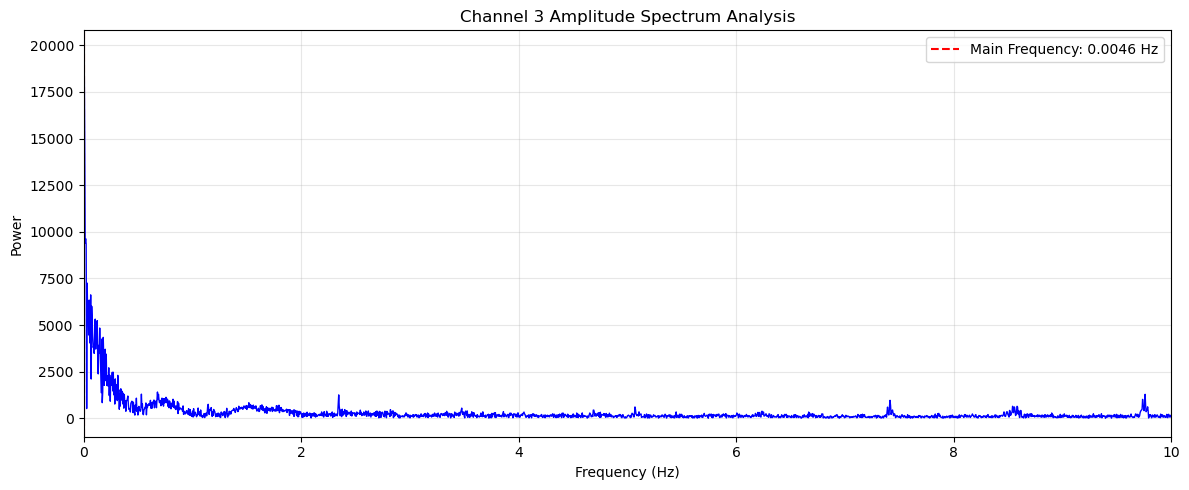

In [18]:
# 计算采样率
if len(timestamps_ms) > 1:
    dt = np.mean(np.diff(timestamps_ms)) / 1000.0  # 转换为秒
    sampling_rate = 1.0 / dt
    print(f"采样率: {sampling_rate:.2f} Hz")
    print(f"采样间隔: {dt:.3f} 秒")
else:
    print("数据点不足，无法计算采样率")
    dt = None
    sampling_rate = None

# 执行FFT
if len(amplitudes) > 4 and sampling_rate and dt > 0:
    # 去除直流成分
    amplitudes_dc_removed = amplitudes - np.mean(amplitudes)
    
    # 应用窗函数（汉明窗）
    window = np.hamming(len(amplitudes_dc_removed))
    amplitudes_windowed = amplitudes_dc_removed * window
    
    # FFT
    fft_vals = np.fft.rfft(amplitudes_windowed)
    fft_freq = np.fft.rfftfreq(len(amplitudes_windowed), dt)
    fft_power = np.abs(fft_vals)
    
    # 找到主频率
    if len(fft_power) > 1:
        main_freq_idx = np.argmax(fft_power[1:]) + 1  # 跳过DC成分
        main_freq = fft_freq[main_freq_idx]
        main_power = fft_power[main_freq_idx]
        
        print(f"\n主频率: {main_freq:.4f} Hz ({main_freq * 60:.2f} 次/分钟)")
        print(f"主频率功率: {main_power:.2f}")
        
        # 绘制频谱
        plt.figure(figsize=(12, 5))
        plt.plot(fft_freq[1:], fft_power[1:], 'b-', linewidth=1)
        plt.axvline(main_freq, color='r', linestyle='--', label=f'Main Frequency: {main_freq:.4f} Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power')
        plt.title(f'Channel {channel} Amplitude Spectrum Analysis')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, min(10, fft_freq[-1]))  # 只显示0-10Hz范围
        plt.tight_layout()
        plt.show()
    else:
        print("FFT结果不足，无法分析")
else:
    print("数据点不足或采样率未知，无法进行FFT分析")


## 8. 多通道对比分析

可以同时分析多个通道的数据。


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\3228236925.py:34: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\3228236925.py:34: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\3228236925.py:34: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\3228236925.py:34: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\3228236925.py:34: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_151

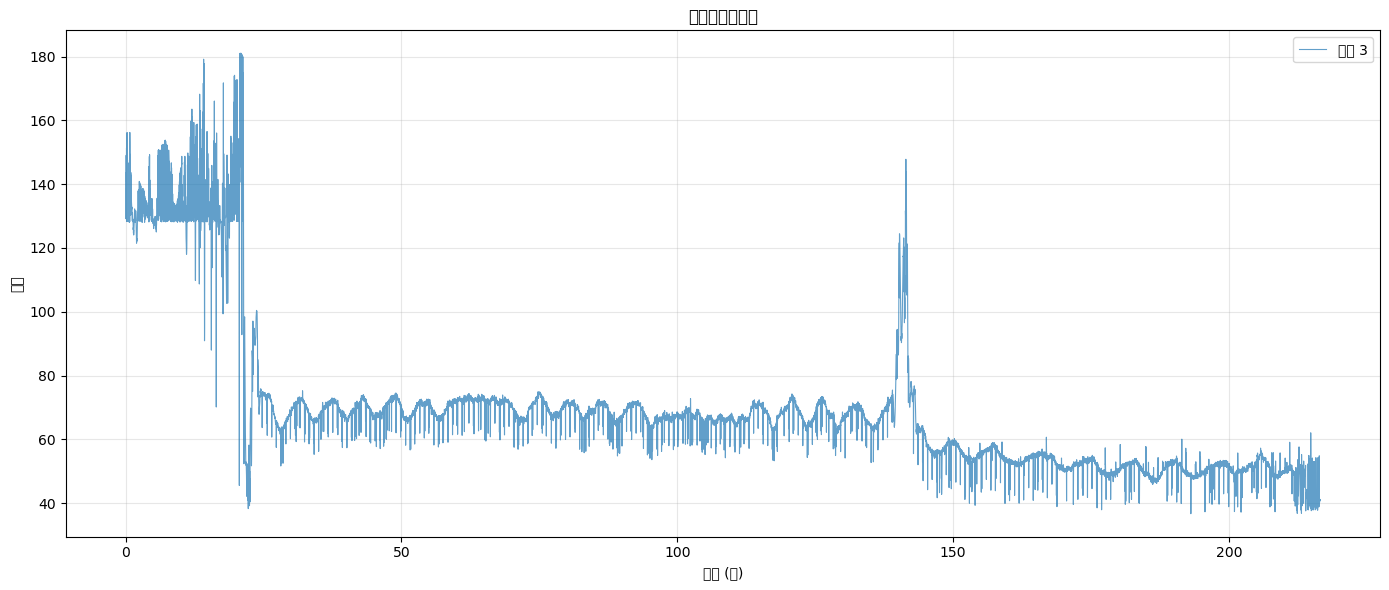


=== 多通道统计对比 ===
通道     均值           标准差          最大值          最小值         
--------------------------------------------------
3      69.98        24.26        181.02       36.67       


In [19]:
# 选择要对比的通道
channels_to_compare = [0, 1, 2, 3, 4]  # 可以修改

# 提取多个通道的数据
channel_data = {}
for ch in channels_to_compare:
    ch_amplitudes = []
    ch_timestamps = []
    
    for frame in frames:
        if ch in frame['channels']:
            ch_amplitudes.append(frame['channels'][ch]['amplitude'])
            ch_timestamps.append(frame['timestamp_ms'])
    
    if ch_amplitudes:
        channel_data[ch] = {
            'amplitudes': np.array(ch_amplitudes),
            'timestamps': np.array(ch_timestamps)
        }

# 绘制多通道对比图
if channel_data:
    plt.figure(figsize=(14, 6))
    
    for ch, data in channel_data.items():
        time_sec = (data['timestamps'] - data['timestamps'][0]) / 1000.0
        plt.plot(time_sec, data['amplitudes'], label=f'通道 {ch}', linewidth=0.8, alpha=0.7)
    
    plt.xlabel('时间 (秒)')
    plt.ylabel('幅值')
    plt.title('多通道幅值对比')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 显示各通道的统计信息
    print("\n=== 多通道统计对比 ===")
    print(f"{'通道':<6} {'均值':<12} {'标准差':<12} {'最大值':<12} {'最小值':<12}")
    print("-" * 50)
    for ch, data in channel_data.items():
        amps = data['amplitudes']
        print(f"{ch:<6} {np.mean(amps):<12.2f} {np.std(amps):<12.2f} "
              f"{np.max(amps):<12.2f} {np.min(amps):<12.2f}")
else:
    print("没有找到可用的通道数据")


## 9. 自定义分析

您可以在这里添加自己的分析代码。

### 数据访问方式

```python
# 访问所有帧
for frame in frames:
    index = frame['index']
    timestamp_ms = frame['timestamp_ms']
    channels = frame['channels']
    
    # 访问特定通道
    if 0 in channels:
        ch_data = channels[0]
        amplitude = ch_data['amplitude']
        phase = ch_data['phase']
        local_amplitude = ch_data['local_amplitude']
        remote_amplitude = ch_data['remote_amplitude']
        # ... 其他字段
```

### 可用的数据字段

每个通道包含以下字段：
- `amplitude`: 总幅值
- `phase`: 总相位（弧度）
- `I`: I分量
- `Q`: Q分量
- `local_amplitude`: Local幅值
- `local_phase`: Local相位（弧度）
- `remote_amplitude`: Remote幅值
- `remote_phase`: Remote相位（弧度）
- `il`, `ql`, `ir`, `qr`: 原始IQ数据


In [20]:
# 在这里添加您的自定义分析代码
# 例如：特定通道的详细分析、相关性分析、异常检测等

# 示例：查找幅值异常大的帧
if len(amplitudes) > 0:
    print("=== 查找幅值异常大的帧 ===")
    threshold = np.mean(amplitudes) + 3 * np.std(amplitudes)  # 3倍标准差
    outliers = []
    
    for i, frame in enumerate(frames):
        channels = frame['channels']
        # 尝试多种方式匹配通道
        ch_data = None
        if channel in channels:
            ch_data = channels[channel]
        elif str(channel) in channels:
            ch_data = channels[str(channel)]
        elif int(channel) in channels:
            ch_data = channels[int(channel)]
        
        if ch_data:
            amp = ch_data['amplitude']
            if amp > threshold:
                outliers.append({
                    'index': frame['index'],
                    'timestamp': frame['timestamp_ms'],
                    'amplitude': amp
                })
    
    if outliers:
        print(f"找到 {len(outliers)} 个异常帧（幅值 > {threshold:.2f}）:")
        for out in outliers[:10]:  # 只显示前10个
            print(f"  帧 {out['index']}: 时间戳={out['timestamp']} ms, 幅值={out['amplitude']:.2f}")
    else:
        print("未发现异常帧")
else:
    print("⚠️  无法进行分析: 没有数据")


=== 查找幅值异常大的帧 ===
找到 243 个异常帧（幅值 > 142.75）:
  帧 3: 时间戳=18542 ms, 幅值=143.62
  帧 5: 时间戳=18582 ms, 幅值=149.06
  帧 8: 时间戳=18642 ms, 幅值=151.32
  帧 10: 时间戳=18682 ms, 幅值=155.29
  帧 12: 时间戳=18722 ms, 幅值=149.43
  帧 13: 时间戳=18742 ms, 幅值=156.20
  帧 14: 时间戳=18762 ms, 幅值=155.33
  帧 16: 时间戳=18802 ms, 幅值=155.91
  帧 17: 时间戳=18822 ms, 幅值=143.95
  帧 21: 时间戳=18902 ms, 幅值=146.70


## I:E吸气/呼气比例

In [ ]:
import numpy as np

print("type(x_detr) =", type(x_detr))
x_arr = np.asarray(x_detr)
print("np.asarray shape =", x_arr.shape, "dtype =", x_arr.dtype)

print("first elem type =", type(x_arr.flat[0]))


type(x_detr) = <class 'dict'>
np.asarray shape = () dtype = object
first elem type = <class 'dict'>


In [23]:
print(x_detr.keys())


dict_keys(['median_filtered', 'detrended_order1', 'detrended_order2'])


In [24]:
# 随便挑一个键（比如第一个）看看更深一层
k0 = next(iter(x_detr))
print("example key:", k0)
print("nested keys:", x_detr[k0].keys() if isinstance(x_detr[k0], dict) else None)


example key: median_filtered
nested keys: None


In [ ]:
import numpy as np

# 选一条连续信号（order1）
x_cont = np.asarray(x_detr["detrended_order1"], dtype=float).reshape(-1)

print("x_cont:", x_cont.shape, "nan?", np.isnan(x_cont).any())

# NaN 
if np.isnan(x_cont).any():
    idx = np.arange(len(x_cont))
    good = ~np.isnan(x_cont)
    x_cont = np.interp(idx, idx[good], x_cont[good])

# bandpass
x_bp = sig_algm.bandpass_filter_zero_phase(
    x_cont, lowcut=lowcut, highcut=highcut, sampling_rate=fs, order=2
)

print("bandpass done:", x_bp.shape)


x_cont: (10803,) nan? False
bandpass done: (10803,)


In [ ]:
energy_ratios = breathing_analysis_results[ch][var]["energy_ratios"]
sample_indices = breathing_analysis_results[ch][var]["sample_indices"]
win_len = len(breathing_analysis_results[ch][var]["windowed_samples"][0])
threshold=0.6

valid_mask = np.zeros(len(x_bp), dtype=bool)
for start, er in zip(sample_indices, energy_ratios):
    if er >= threshold:
        start = int(start)
        end = min(start + win_len, len(valid_mask))
        valid_mask[start:end] = True

print("valid coverage:", valid_mask.mean())


valid coverage: 0.9765805794686662


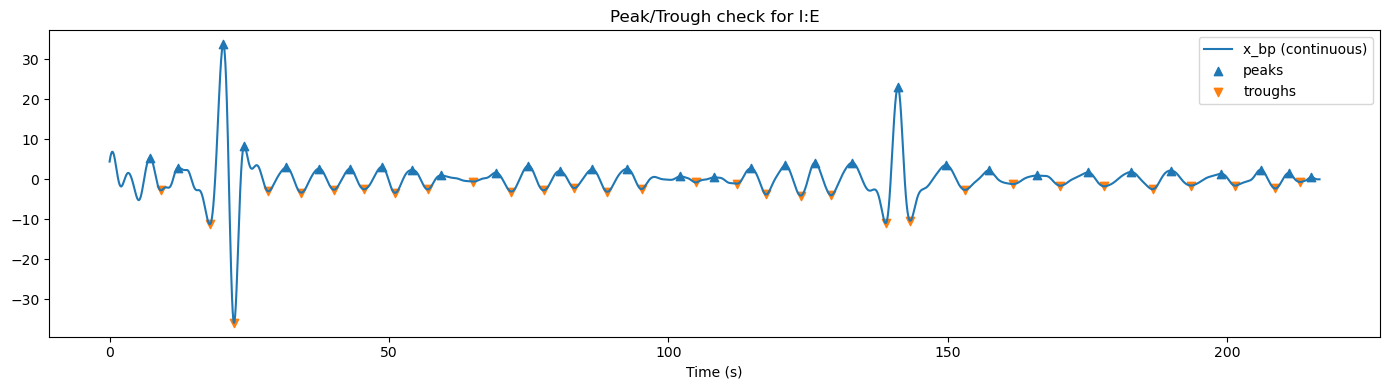

peaks: 32 troughs: 31


In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

x_for_peaks = x_bp.copy()
x_for_peaks[~valid_mask] = np.nan

# 把 NaN 替换成最小值（屏蔽掉无效区域）
min_val = np.nanmin(x_for_peaks)
x_for_peaks = np.where(np.isnan(x_for_peaks), min_val, x_for_peaks)

min_distance = int(2.0 * fs)  # 先用 2s，符合现在 0.15~0.2Hz（周期5~7s）

peaks, _ = find_peaks(x_for_peaks, distance=min_distance, prominence=np.nanstd(x_bp)*0.2)
troughs, _ = find_peaks(-x_for_peaks, distance=min_distance, prominence=np.nanstd(x_bp)*0.2)

# 只保留有效区域内的峰谷
peaks = peaks[valid_mask[peaks]]
troughs = troughs[valid_mask[troughs]]

t = np.arange(len(x_bp)) / fs

plt.figure(figsize=(14,4))
plt.plot(t, x_bp, label="x_bp (continuous)")
plt.scatter(t[peaks], x_bp[peaks], marker="^", label="peaks")
plt.scatter(t[troughs], x_bp[troughs], marker="v", label="troughs")
plt.legend()
plt.title("Peak/Trough check for I:E")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

print("peaks:", len(peaks), "troughs:", len(troughs))


In [31]:
energy_ratios = breathing_analysis_results[ch][var]["energy_ratios"]
sample_indices = breathing_analysis_results[ch][var]["sample_indices"]
win_len = len(breathing_analysis_results[ch][var]["windowed_samples"][0])

print("len(x_bp) =", len(x_bp))
print("win_len =", win_len)
print("num_windows =", len(sample_indices), len(energy_ratios))

print("sample_indices type:", type(sample_indices))
print("first 10 sample_indices:", sample_indices[:10])

print("min/max sample_indices:", np.min(sample_indices), np.max(sample_indices))
print("valid windows count:", np.sum(np.array(energy_ratios) >= threshold))


len(x_bp) = 10803
win_len = 1000
num_windows = 197 197
sample_indices type: <class 'list'>
first 10 sample_indices: [0, 50, 100, 150, 200, 250, 300, 350, 400, 450]
min/max sample_indices: 0 9800
valid windows count: 167


**Inspiration (I)：吸气阶段时间**

**Expiration (E)：呼气阶段时间**

**I:E ratio = T_inspiration / T_expiration**

In [32]:
# 合并峰谷并排序
events = np.concatenate([
    np.column_stack([peaks, np.ones(len(peaks))]),     # 1 = peak
    np.column_stack([troughs, np.zeros(len(troughs))]) # 0 = trough
])

# 按时间排序
events = events[np.argsort(events[:, 0])]

# 只保留 trough → peak → trough 这种完整周期
cycles = []
for i in range(len(events) - 2):
    if events[i,1] == 0 and events[i+1,1] == 1 and events[i+2,1] == 0:
        cycles.append(events[i:i+3, 0].astype(int))

print("valid cycles:", len(cycles))


valid cycles: 30


In [36]:
Tin = []
Tex = []
IE = []

for t0, p, t1 in cycles:
    tin = (p - t0) / fs
    tex = (t1 - p) / fs
    if tin > 0 and tex > 0:
        Tin.append(tin)
        Tex.append(tex)
        IE.append(tin / tex)

Tin = np.array(Tin)
Tex = np.array(Tex)
IE = np.array(IE)

print("Tin mean ± std:", Tin.mean(), Tin.std())
print("Tex mean ± std:", Tex.mean(), Tex.std())
print("I:E mean:", IE.mean())
print("I:E std:", IE.std())
print("I:E mean ± std:", IE.mean(), IE.std())


Tin mean ± std: 3.5605495278652106 1.1864095146389193
Tex mean ± std: 3.236437943590694 1.0549802953522984
I:E mean: 1.182370326263888
I:E std: 0.45674885310044794
I:E mean ± std: 1.182370326263888 0.45674885310044794


In [37]:
def summarize_ie(name, IE, energy_ratios, threshold):
    IE = np.asarray(IE)
    IE = IE[~np.isnan(IE)]
    valid_windows = np.sum(np.asarray(energy_ratios) >= threshold)
    total_windows = len(energy_ratios)

    out = {
        "name": name,
        "n_cycles": len(IE),
        "IE_mean": float(np.mean(IE)) if len(IE)>0 else np.nan,
        "IE_std": float(np.std(IE)) if len(IE)>0 else np.nan,
        "IE_median": float(np.median(IE)) if len(IE)>0 else np.nan,
        "IE_IQR": float(np.quantile(IE,0.75)-np.quantile(IE,0.25)) if len(IE)>0 else np.nan,
        "valid_windows_ratio": float(valid_windows/total_windows) if total_windows>0 else np.nan,
    }
    return out

cs_summary = summarize_ie("DF_50HZ", IE, energy_ratios, threshold)
cs_summary


{'name': 'DF_50HZ',
 'n_cycles': 30,
 'IE_mean': 1.182370326263888,
 'IE_std': 0.45674885310044794,
 'IE_median': 1.127262443438914,
 'IE_IQR': 0.3711329050764882,
 'valid_windows_ratio': 0.8477157360406091}

In [38]:
np.save("DF_50Hz_IE.npy", IE)


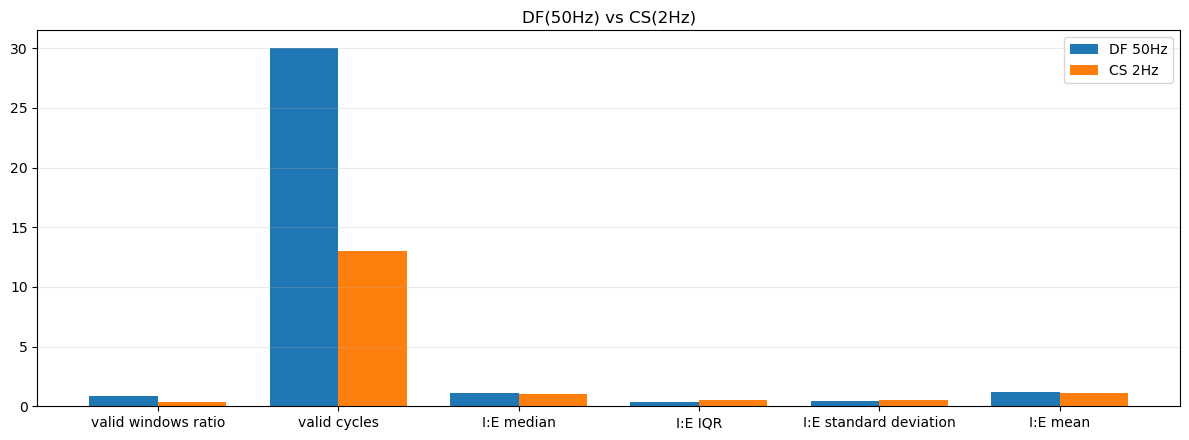

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15188\2957885131.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([DF_IE, CS_IE], labels=["DF 50Hz", "CS 2Hz"], showfliers=True)


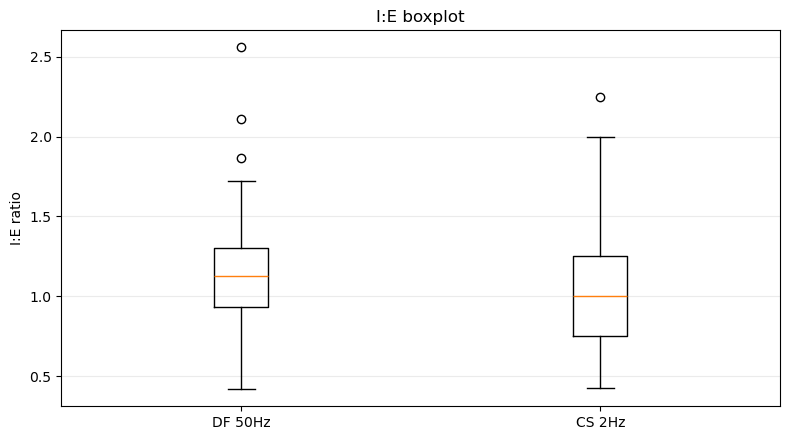

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 综合df和cs的summary
df_summary = {'name': 'DF_50HZ',
 'n_cycles': 30,
 'IE_mean': 1.182370326263888,
 'IE_std': 0.45674885310044794,
 'IE_median': 1.127262443438914,
 'IE_IQR': 0.3711329050764882,
 'valid_windows_ratio': 0.8477157360406091}

cs_summary = {'name': 'CS_2Hz',
 'n_cycles': 13,
 'IE_mean': 1.0736263736263736,
 'IE_std': 0.5277048481056101,
 'IE_median': 1.0,
 'IE_IQR': 0.5,
 'valid_windows_ratio': 0.37777777777777777}

# 图A：关键指标对比（bar chart
metrics = ["valid_windows_ratio", "n_cycles", "IE_median", "IE_IQR", "IE_std", "IE_mean"]
labels  = ["valid windows ratio", "valid cycles", "I:E median", "I:E IQR", "I:E standard deviation", "I:E mean"]

df_vals = [df_summary[m] for m in metrics]
cs_vals = [cs_summary[m] for m in metrics]

x = np.arange(len(metrics))
w = 0.38

plt.figure(figsize=(12,4.5))
plt.bar(x - w/2, df_vals, width=w, label="DF 50Hz")
plt.bar(x + w/2, cs_vals, width=w, label="CS 2Hz")
plt.xticks(x, labels, rotation=0)
plt.title("DF(50Hz) vs CS(2Hz)")
plt.grid(True, axis="y", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# 图B：I:E 分布（boxplot）
DF_IE = np.load("DF_50Hz_IE.npy")
CS_IE = np.load("CS_2Hz_IE.npy")
try:
    DF_IE = np.asarray(DF_IE, dtype=float)
    CS_IE = np.asarray(CS_IE, dtype=float)
    DF_IE = DF_IE[~np.isnan(DF_IE)]
    CS_IE = CS_IE[~np.isnan(CS_IE)]

    plt.figure(figsize=(8,4.5))
    plt.boxplot([DF_IE, CS_IE], labels=["DF 50Hz", "CS 2Hz"], showfliers=True)
    plt.title("I:E boxplot")
    plt.ylabel("I:E ratio")
    plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()
except NameError:
    print("未找到 DF_IE / CS_IE。")


### 总结

**1. 有效数据覆盖率与可用窗口比例**

从有效窗口比例（valid windows ratio）来看，DF（50 Hz）显著优于 CS（2 Hz）：

DF（50 Hz）：有效窗口比例约 0.85

CS（2 Hz）：有效窗口比例约 0.38

这表明，在相同的能量判据下，低采样率数据更容易被判定为不可用窗口。CS 数据中超过一半的时间窗口未能通过能量阈值筛选，导致连续可分析的时间区段明显减少。相比之下，DF 数据在时间上具有更高的连续性和可用性，更适合进行后续的周期级分析。

**2. 有效呼吸周期数量对比**

在完成峰谷检测并构造完整呼吸周期后，两种采样模式下得到的有效周期数量存在明显差异：

DF（50 Hz）：共提取 30 个有效呼吸周期

CS（2 Hz）：仅提取 13 个有效呼吸周期

这一差异直接反映了采样率对时间分辨率的影响。DF 数据能够更精确地定位吸气与呼气的起止点，从而保留更多完整周期；而 CS 数据由于时间分辨率较低，在峰谷定位时更容易出现遗漏或合并现象，导致可统计的呼吸周期数量显著减少。

**3. I:E 的中心趋势特征**

从 I:E 的中心趋势指标（均值与中位数）来看，两种采样模式在量级上保持一致：

DF（50 Hz）：I:E 中位数约 1.13

CS（2 Hz）：I:E 中位数为 1.00

这说明 CS（2 Hz）在总体上仍能够反映吸气与呼气时间大致对称的生理事实，在定性层面并未给出明显偏离的估计结果。然而，DF 数据中 I:E 的中位数略高于 1，显示出对吸、呼时间之间细微不对称性的更高敏感度。

**4. I:E 的离散程度与稳定性**

在离散程度方面，CS（2 Hz）表现出更大的波动性：

DF（50 Hz）：

I:E 标准差 ≈ 0.46

I:E 四分位距（IQR）≈ 0.37

CS（2 Hz）：

I:E 标准差 ≈ 0.53

I:E 四分位距（IQR）≈ 0.50

这表明 CS 数据下的 I:E 估计结果分布更为分散，稳定性较差。其主要原因在于低采样率条件下，峰谷时间只能落在较粗的离散时间点上，微小的时间误差在计算 I:E 这一比值型指标时会被放大，从而导致更大的周期间波动。

**5. 综合分析与结论**

综合以上结果可以得出以下结论：

CS（2 Hz）能够在整体量级上估计 I:E，但结果稳定性有限，且可用时间窗口与有效周期数量明显不足；

DF（50 Hz）在有效数据覆盖率、周期数量以及 I:E 稳定性方面均表现出明显优势；

对于仅关注呼吸节律或粗略比例估计的场景，CS 数据可能仍具有一定参考价值；

然而，对于依赖周期级时间精度的指标（如 I:E），较高的采样率对于获得稳定、可信的统计结果是必要的。